In [1]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from src.utils.data_utils import get_related_videos_with_keywords, keyword_searcher
from src.utils.general_utils import plot_wordcloud
from src.utils.evaluation_utils import diff_in_diff
from sklearn.linear_model import LinearRegression



In [2]:
def get_all_tags(df: pd.DataFrame) -> list[str]:
    df['tags'] = df['tags'].str.lower()
    df['tags'] = df['tags'].str.replace("world cup", "world_cup")
    df['tags'] = df['tags'].str.replace("table tennis", "table_tennis")
    df['tags'] = df['tags'].str.replace("ping pong", "table_tennis")
    
    all_tags = []
    for tags in df['tags']:
        tag_list = tags.split(",") # "a, b c, d" -> ["a", "b c", "d"]
        for sentence in tag_list:
            all_tags.extend(sentence.split()) # "b c" -> ["b", "c"]
    
    return all_tags

In [3]:
DATA_PATH = "../data"
df_vd_sports = pd.read_parquet(DATA_PATH+"/filtered_sport_category_metadata.parquet",engine="fastparquet")
# Change upload_date to datetime
df_vd_sports["upload_date"] = pd.to_datetime(df_vd_sports["upload_date"], format="%Y-%m-%d %H:%M:%S")
df_vd_sports['tags'] = df_vd_sports['tags'].str.lower()
df_vd_sports['upload_year_month'] = df_vd_sports['upload_date'].dt.to_period('M') 
# engagement rate \text{Engagement Rate} = (like_count + dislike_count)\view_count
df_vd_sports['engagement_rate'] = (df_vd_sports['like_count'] + df_vd_sports['dislike_count']) / df_vd_sports['view_count']

Replace tags

In [4]:
df_vd_sports['tags'] = df_vd_sports['tags'].str.replace("world cup", "world_cup")
df_vd_sports['tags'] = df_vd_sports['tags'].str.replace("table tennis", "table_tennis")
df_vd_sports['tags'] = df_vd_sports['tags'].str.replace("ping pong", "table_tennis")

In [5]:
df_vd_sports.head()

categories                channel_id                  crawl_date  \
0     Sports  UCzWn_gTaXyH5Idyo8Raf7_A  2019-11-03 16:39:57.427254   
1     Sports  UCzWn_gTaXyH5Idyo8Raf7_A  2019-11-03 16:39:58.108323   
2     Sports  UCzWn_gTaXyH5Idyo8Raf7_A  2019-11-03 16:39:58.773085   
3     Sports  UCzWn_gTaXyH5Idyo8Raf7_A  2019-11-03 16:39:59.465346   
4     Sports  UCzWn_gTaXyH5Idyo8Raf7_A  2019-11-03 16:40:00.188768   

                                         description  dislike_count  \
0  Can I catch 100 lbs of catfish LIVE. Me and Ja...           35.0   
1                                                              15.0   
2  Are you ready to enter the high fashion world ...           78.0   
3  Saltwater fishing out of Newquay Cornwall UK. ...           70.0   
4  My family spent 3 weeks touring England and fi...           73.0   

    display_id  duration  like_count  \
0  JOeSxtcNdHQ      8620      1673.0   
1  EPMLTw2zINw       355      1297.0   
2  Y1_pK68iSYQ       603      3305.0   
3  jF8TSo3ZfTc      1426      1889.0   
4  Gp00dNaVouo       990      2699.0   

                                                tags  \
0  catfishing,fishing,fishing challenge,catfish,c...   
1                                                      
2  catfishing,how to catch catfish,fishing,classy...   
3  fishing,fishing uk,angling,sea angling,sea ang...   
4  fishing,catfish,wels catfish,how to catch catf...   

                                               title upload_date  view_count  \
0                  Catching 100 lbs of Catfish 🔴Live  2019-10-01     48737.0   
1                                            big cat  2019-10-01     19999.0   
2  Classy Catfishing - How to Catch Catfish the P...  2019-09-28     58518.0   
3  2 Day Saltwater Fishing Catch & Cook - UK Sea ...  2019-09-21     71998.0   
4  How to Catch Wels Catfish - Fishing for Catfis...  2019-09-14    101924.0   

  upload_year_month  engagement_rate  
0           2019-10         0.035045  
1           2019-10         0.065603  
2           2019-09         0.057811  
3           2019-09         0.027209  
4           2019-09         0.027197

Extract sports 

In [6]:

target_sports = [
    "football","basketball","wrestling","soccer","boxing","hockey","mma","golf","baseball","tennis","cricket","rugby","gymnastics"
,"volleyball","skating"]


target_sport_data = pd.DataFrame()
for sport in target_sports:
    filtered_sport_data = df_vd_sports[df_vd_sports['tags'].apply(lambda x: sport in x.split(','))]
    target_sport_data = pd.concat([target_sport_data, filtered_sport_data])

In [7]:
target_sport_data=target_sport_data.drop_duplicates(subset=['display_id']).reset_index(drop=True)

In [41]:
def sport_analysis(data_all,data_sport,sport_name=None):
    monthly_count = data_sport.groupby('upload_year_month').size()
    plt.figure(figsize=(12, 8))
    monthly_count.plot(kind='line', figsize=(12, 6), colormap='tab20', linewidth=2)

    plt.title('Monthly Upload Counts for {}'.format(sport_name), fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Number of Uploads', fontsize=14)
    # plt.legend(title='Sports', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    autocorrelation = monthly_count.autocorr(lag=1)
    print("Autocorrelation: ", autocorrelation)


    #------------------------------
    print("periodic analysis")
    # フーリエ変換の計算
    fft_values = np.fft.fft(monthly_count)

    # 振幅スペクトルを取得（絶対値）
    fft_amplitude = np.abs(fft_values)
    fft_amplitude /= len(monthly_count)
    print("len",len(monthly_count))

    # 周波数軸を計算
    frequencies = np.fft.fftfreq(len(fft_values))

    # 正の周波数のみを使用
    positive_frequencies = frequencies[:len(frequencies)//2]
    positive_amplitudes = fft_amplitude[:len(fft_amplitude)//2]

    # 周期（月数）に変換
    periods = 1 / positive_frequencies

    # 周期が無限大になる値（周波数が0の場合）を除去
    periods = periods[1:]  # 周波数0の部分を除く
    positive_amplitudes = positive_amplitudes[1:]  # 同様に振幅も除去
    
    threshold = 100
    filtered_periods = periods[positive_amplitudes >= threshold]
    filtered_amplitudes = positive_amplitudes[positive_amplitudes >= threshold]
    print(filtered_periods)
    print(filtered_amplitudes)
    filtered_periods=filtered_periods[1:]
    filtered_amplitudes=filtered_amplitudes[1:]

    # プロット
    plt.figure(figsize=(12, 8))
    plt.bar(filtered_periods, filtered_amplitudes, width=0.5, color='blue')
    plt.title('Frequency Spectrum, {}'.format(sport_name), fontsize=16)
    plt.xlabel('Period (Months)', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    plt.xlim(0,100)
    plt.grid(True)

    # x軸のラベルを細かく調整
    plt.xticks(np.arange(0, 100 + 1, step=3), rotation=45)

    plt.tight_layout()
    plt.show()
    #------------------------------

    total_sports_videos = data_all.groupby('upload_year_month').size()

    sport_video_count = data_sport.groupby('upload_year_month').size()

    golf_trend = (sport_video_count / total_sports_videos).fillna(0)  # NaNを0で置き換える
    plt.figure(figsize=(12, 6))
    golf_trend.plot(kind='line', figsize=(12, 6), colormap='tab20', linewidth=2)

    plt.title('{} Video Upload Trends'.format(sport_name))
    plt.xlabel('Month')
    plt.ylabel('Proportion of {} related video'.format(sport_name))
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    #-----------------------------
    # user engagement
    monthly_engagement = data_sport.groupby('upload_year_month')['engagement_rate'].agg(['mean', 'median']).reset_index()

    tick_positions = range(0, len(monthly_engagement), 4)
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_engagement['upload_year_month'].astype(str), monthly_engagement['mean'], marker='o', label='Mean Engagement Rate')
    plt.plot(monthly_engagement['upload_year_month'].astype(str), monthly_engagement['median'], marker='s', label='Median Engagement Rate', linestyle='--')
    plt.title('Monthly Engagement Rate of {}'.format(sport_name))
    plt.xlabel('Month')
    plt.ylabel('Engagement Rate')
    plt.xticks(tick_positions, monthly_engagement['upload_year_month'].astype(str).iloc[tick_positions], rotation=45)  # ラベルを間引く
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # #-----------------------------
    # # q score
    # data_sport['q_score']=(data_sport['like_count'] - data_sport['dislike_count']) / (data_sport['like_count'] + data_sport['dislike_count'])
    # monthly_engagement = data_sport.groupby('upload_year_month')['q_score'].agg(['mean', 'median']).reset_index()

    # tick_positions = range(0, len(monthly_engagement), 4)
    # plt.figure(figsize=(12, 6))
    # plt.plot(monthly_engagement['upload_year_month'].astype(str), monthly_engagement['mean'], marker='o', label='Mean Q score Rate')
    # plt.plot(monthly_engagement['upload_year_month'].astype(str), monthly_engagement['median'], marker='s', label='Median Q score Rate', linestyle='--')
    # plt.title('Monthly Q score of {}'.format(sport_name))
    # plt.xlabel('Month')
    # plt.ylabel('Q score')
    # plt.xticks(tick_positions, monthly_engagement['upload_year_month'].astype(str).iloc[tick_positions], rotation=45)  # ラベルを間引く
    # plt.legend()
    # plt.grid()
    # plt.tight_layout()
    # plt.show()

    #-------------------------------------
    # how many channels are active over time???

    

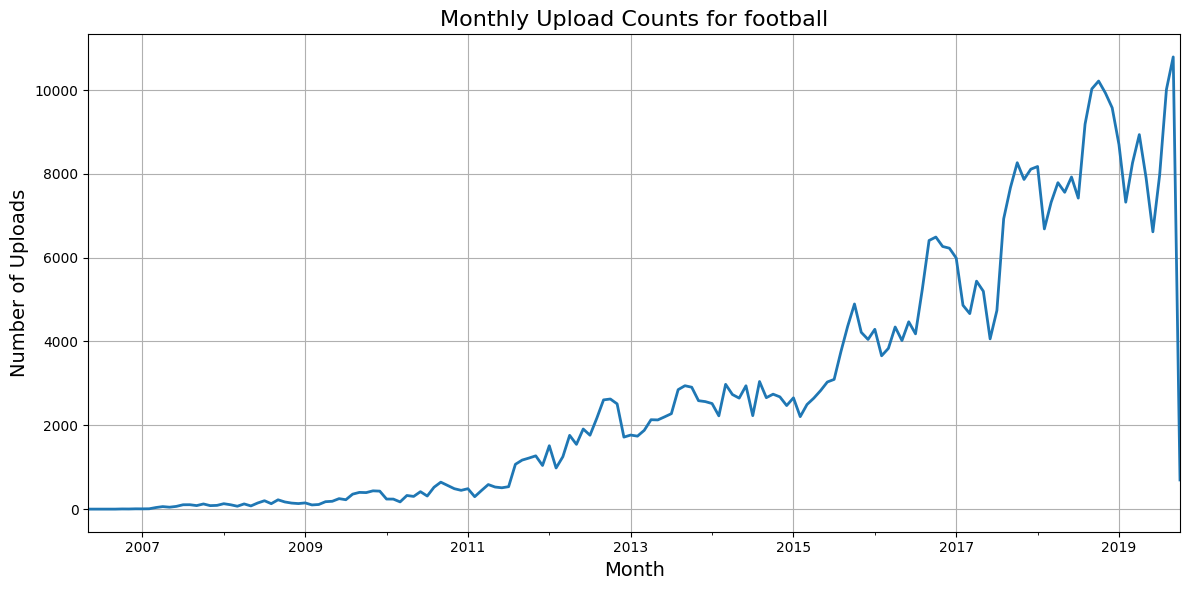

Autocorrelation:  0.9489911100814488
periodic analysis
len 162
[162.          81.          54.          40.5         32.4
  27.          23.14285714  20.25        18.          16.2
  14.72727273  12.46153846  11.57142857  10.8         10.125
   9.52941176   9.           6.           5.78571429   5.5862069
   3.95121951]
[1586.92852631  868.30471959  565.7295623   392.38755855  331.32600886
  242.5841021   131.20804411  157.49166633  108.08813603  158.6243868
  123.48569317  129.79077099  208.10519096  179.64256489  161.36257421
  101.34874979  107.62955871  105.19166284  106.46780477  100.45914789
  113.84006843]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


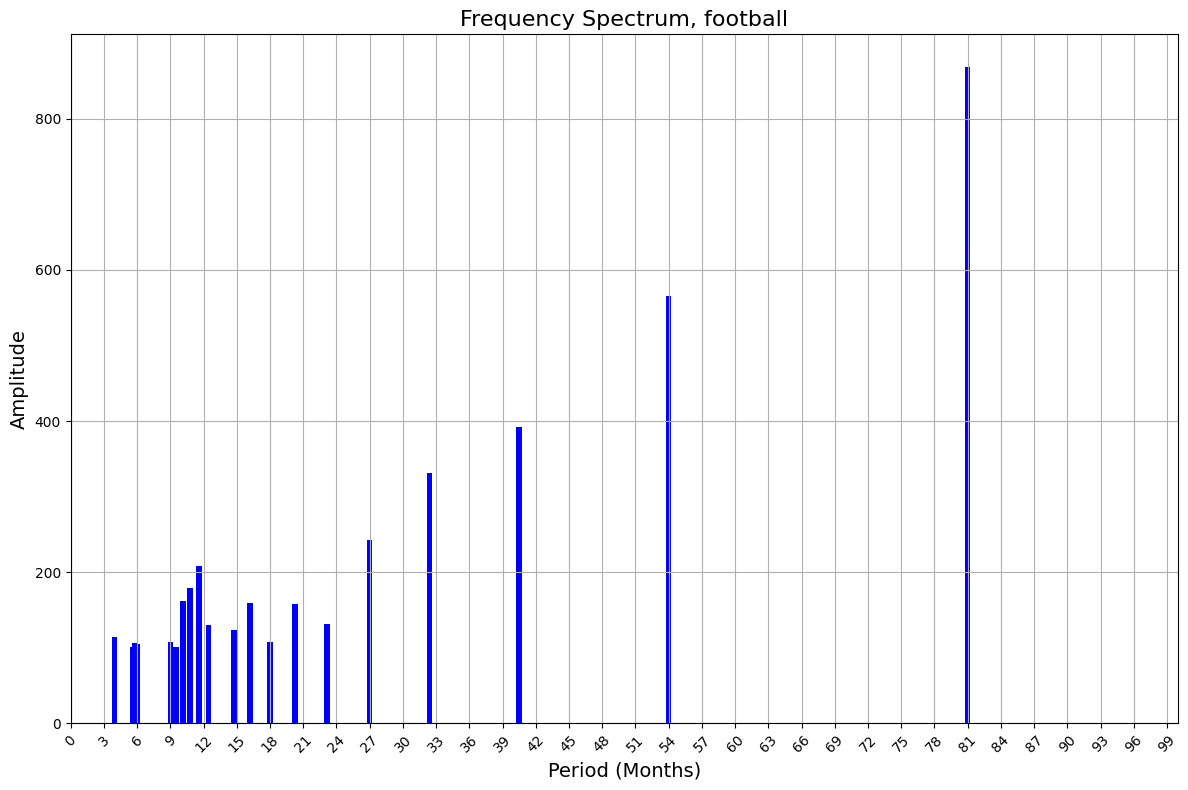

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


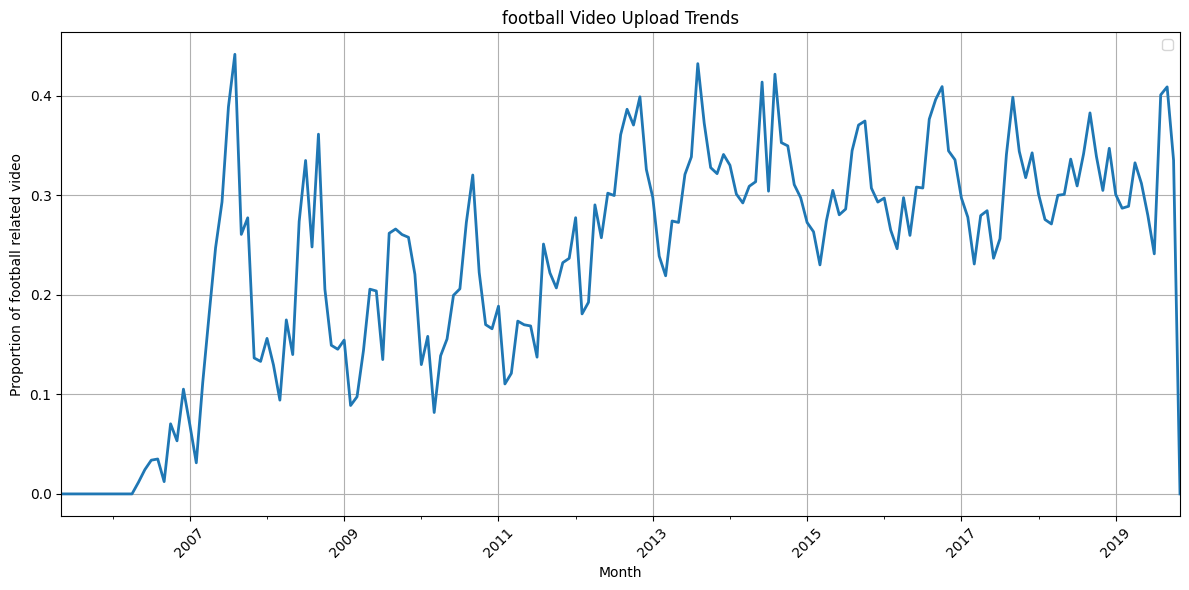

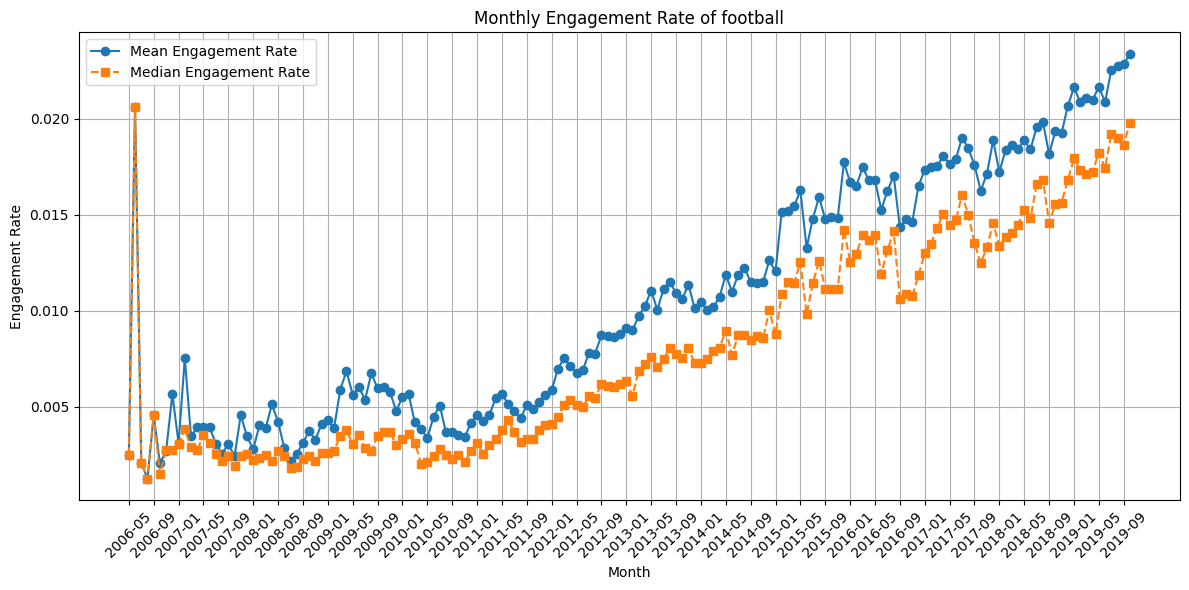

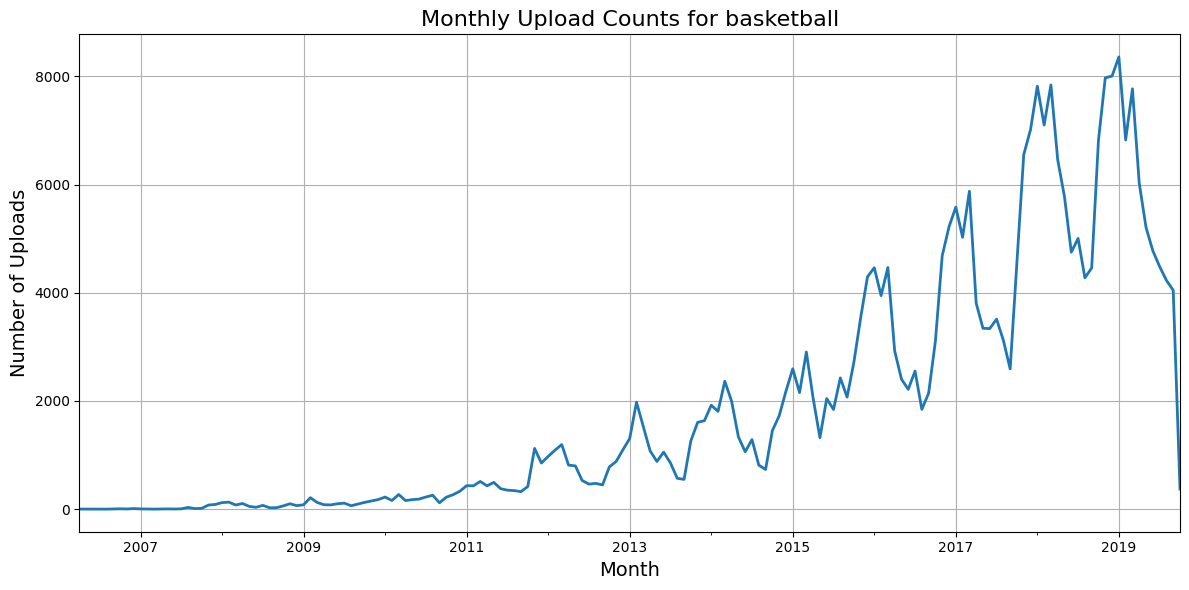

Autocorrelation:  0.9594780067021372
periodic analysis
len 162
[162.          81.          54.          40.5         32.4
  27.          23.14285714  20.25        14.72727273  13.5
  12.46153846  11.57142857  10.8       ]
[1183.14918216  646.96894218  398.50651408  320.28901485  244.14698772
  146.17058019  119.72180765  133.82568325  173.84779157  175.08065612
  269.66792471  253.67179541  122.28939595]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


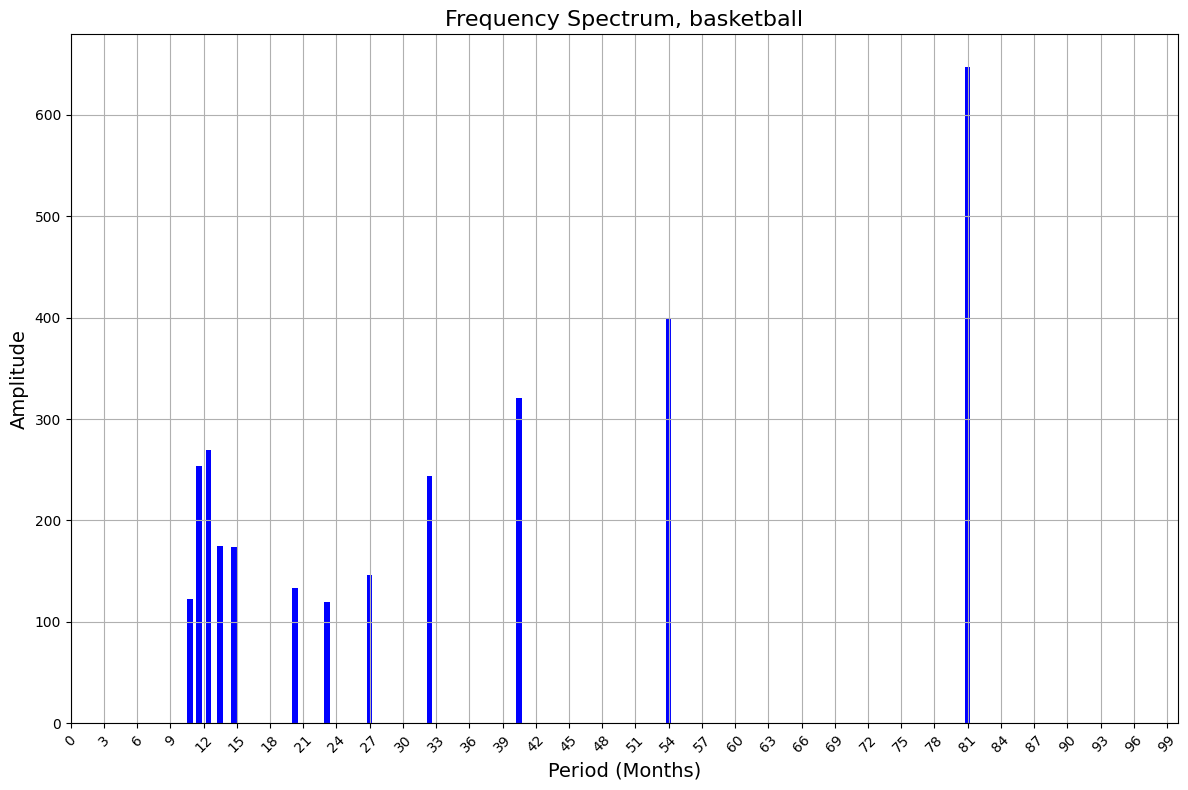

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


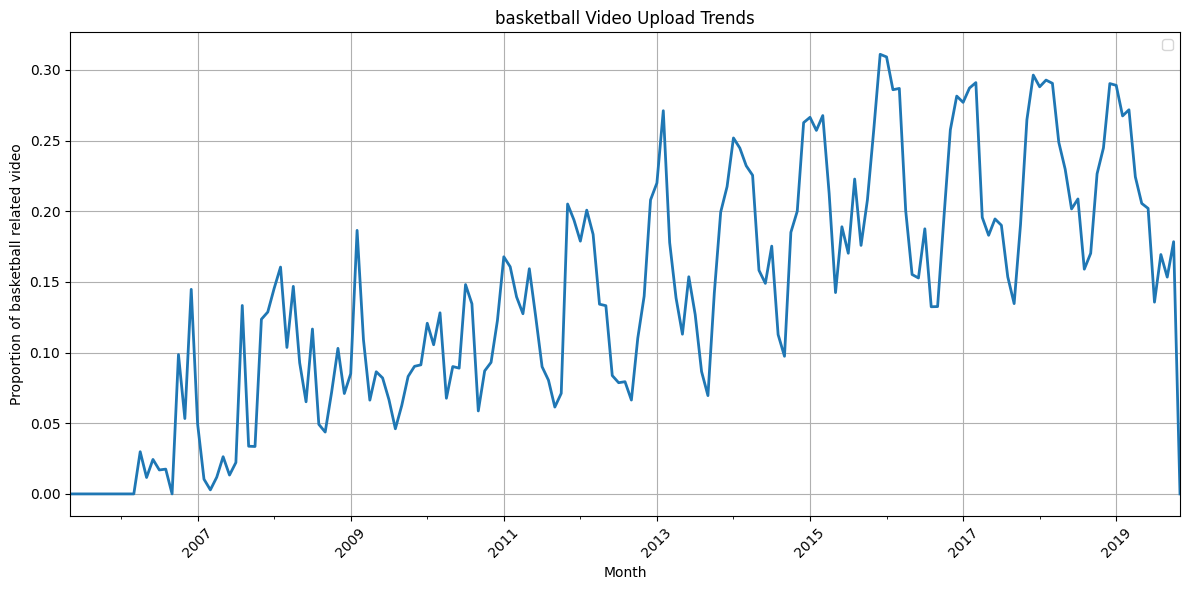

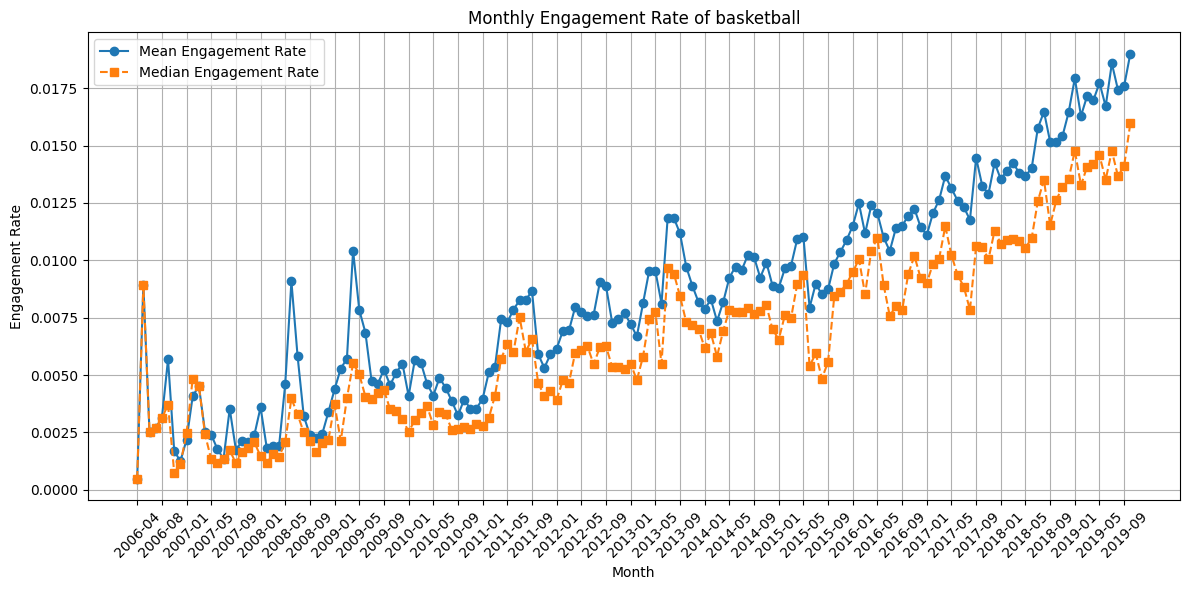

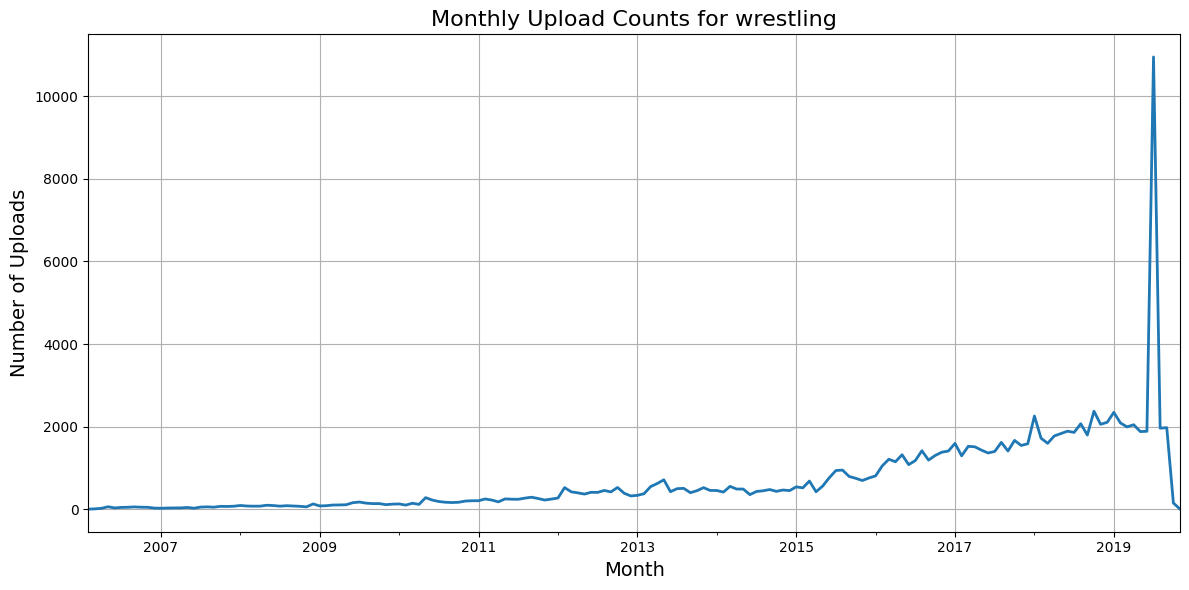

Autocorrelation:  0.5225179000236065
periodic analysis
len 166
[166.          83.          55.33333333  41.5         33.2       ]
[387.76858077 244.16560126 134.54629951 120.10175345 117.25678409]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


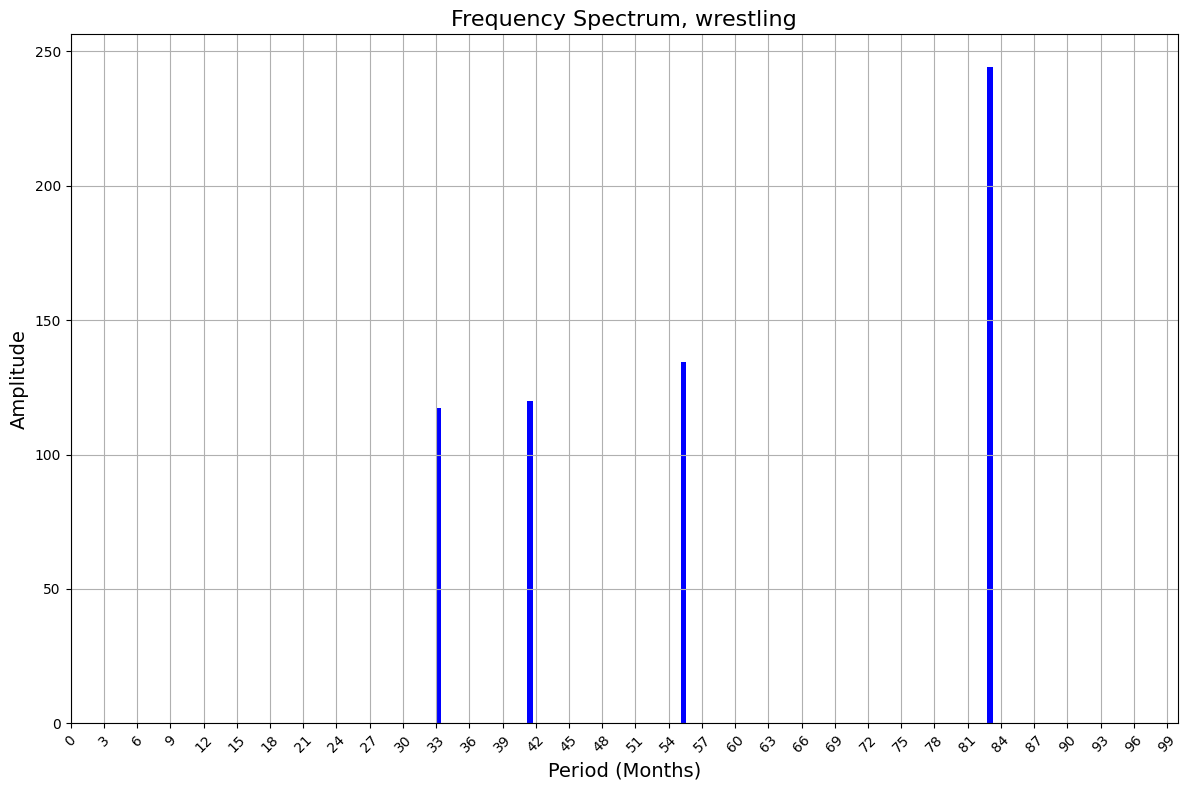

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


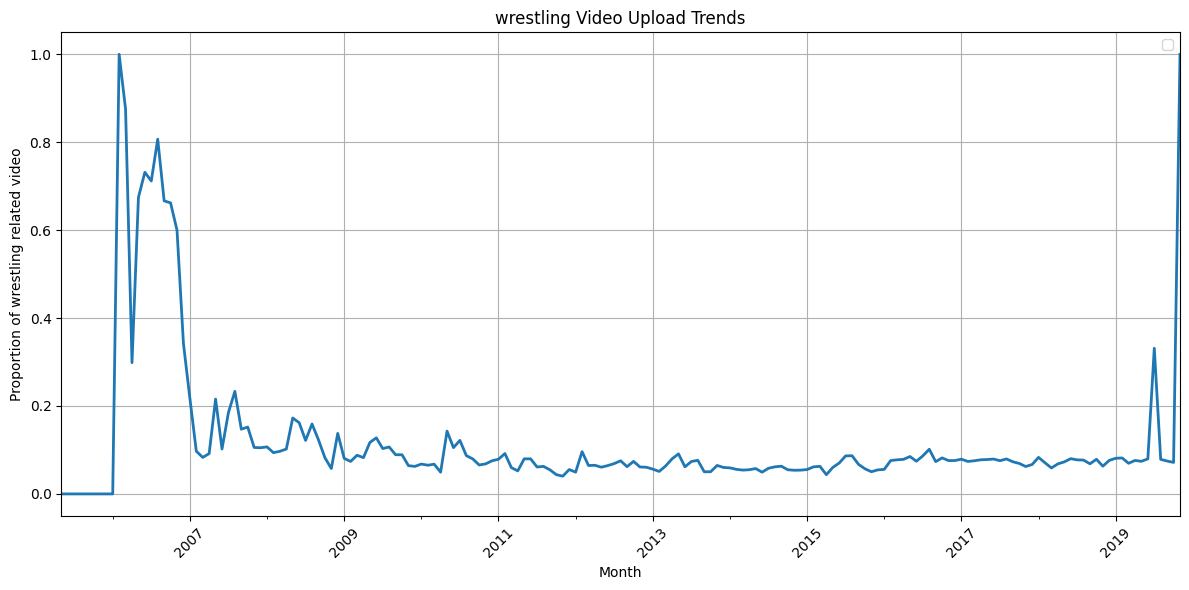

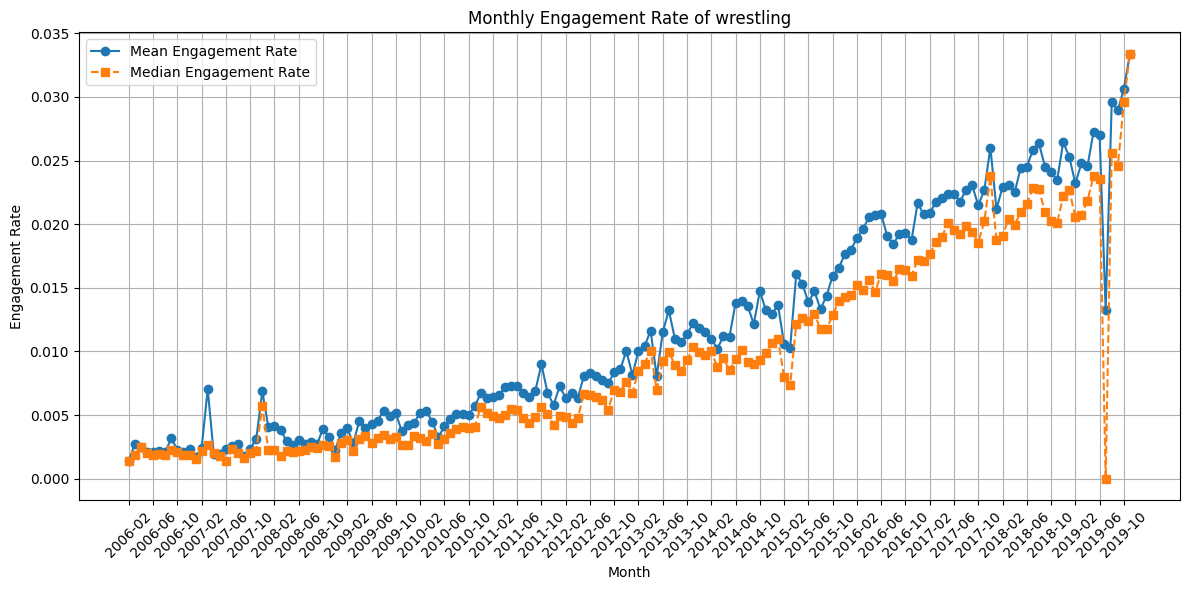

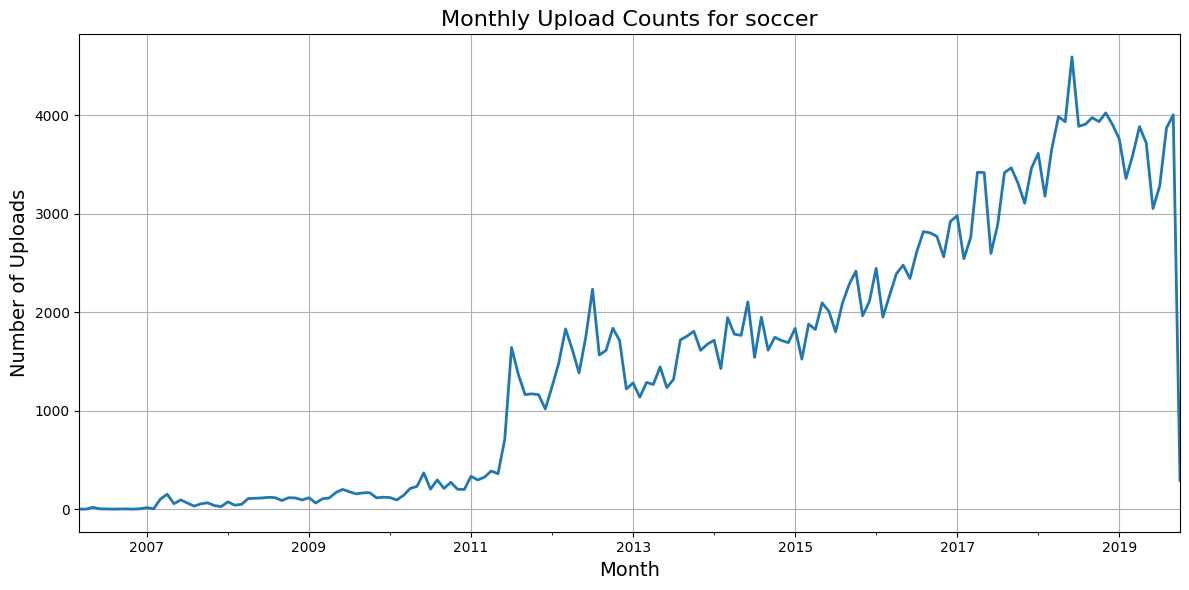

Autocorrelation:  0.9575172113914802
periodic analysis
len 164
[164.          82.          54.66666667  41.          27.33333333]
[736.42831876 389.0956454  221.08021577 201.17885273 131.10039072]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


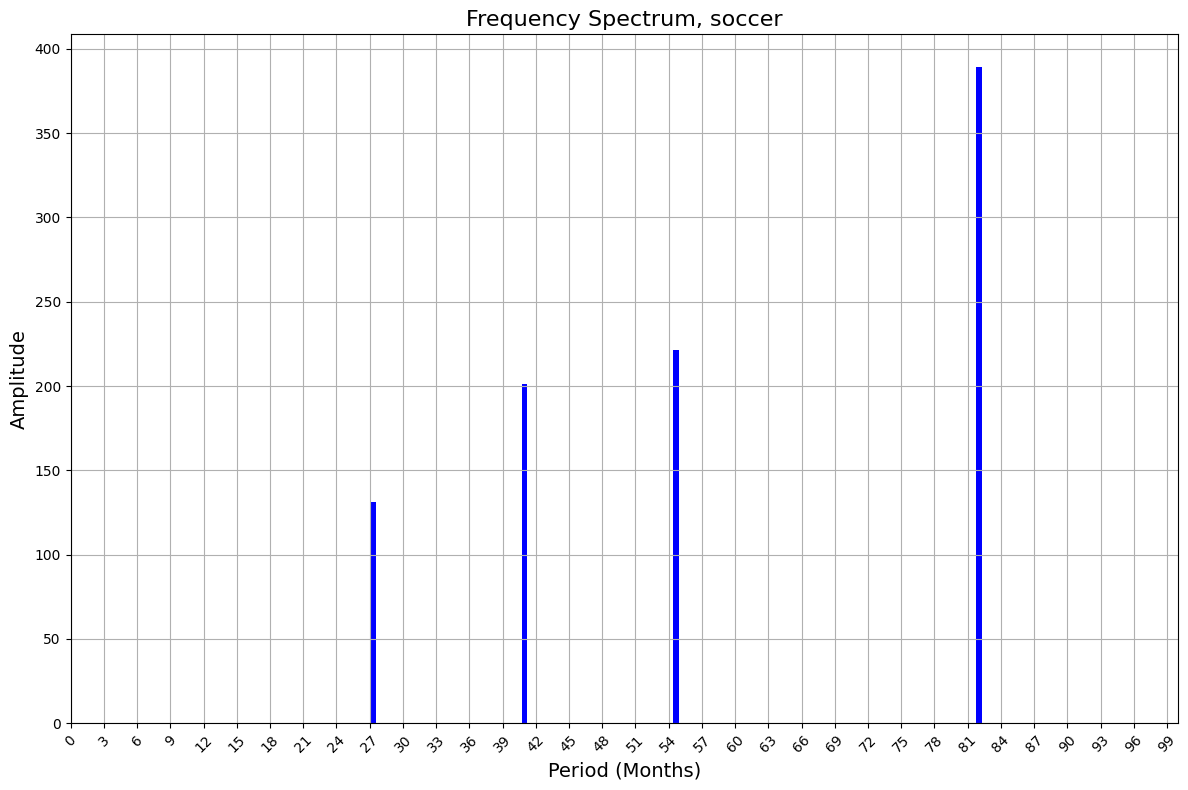

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


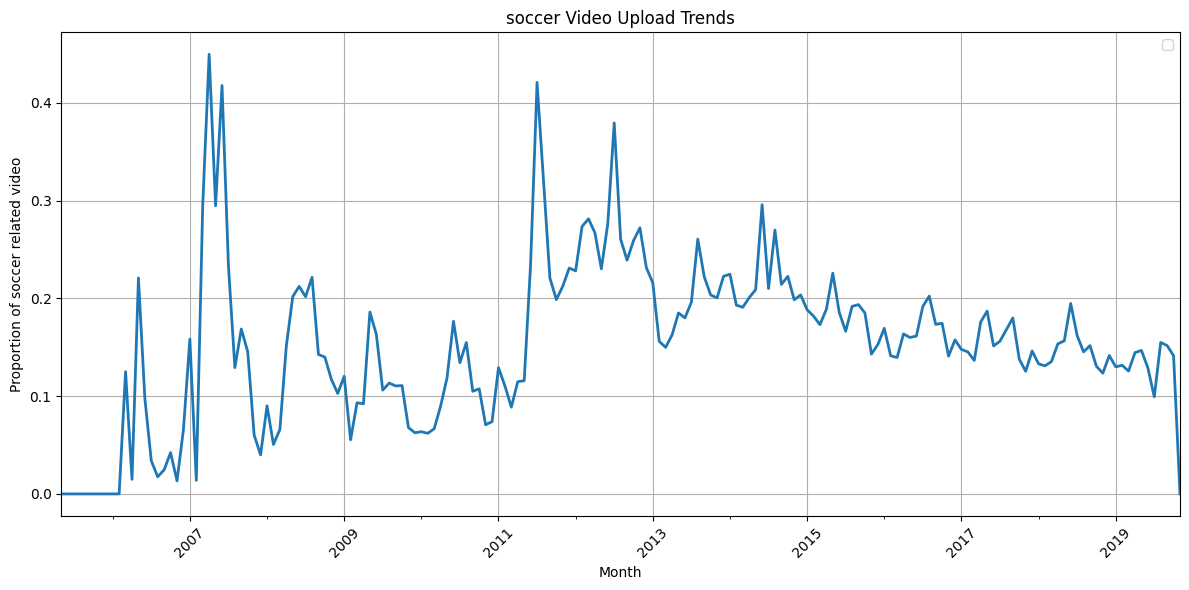

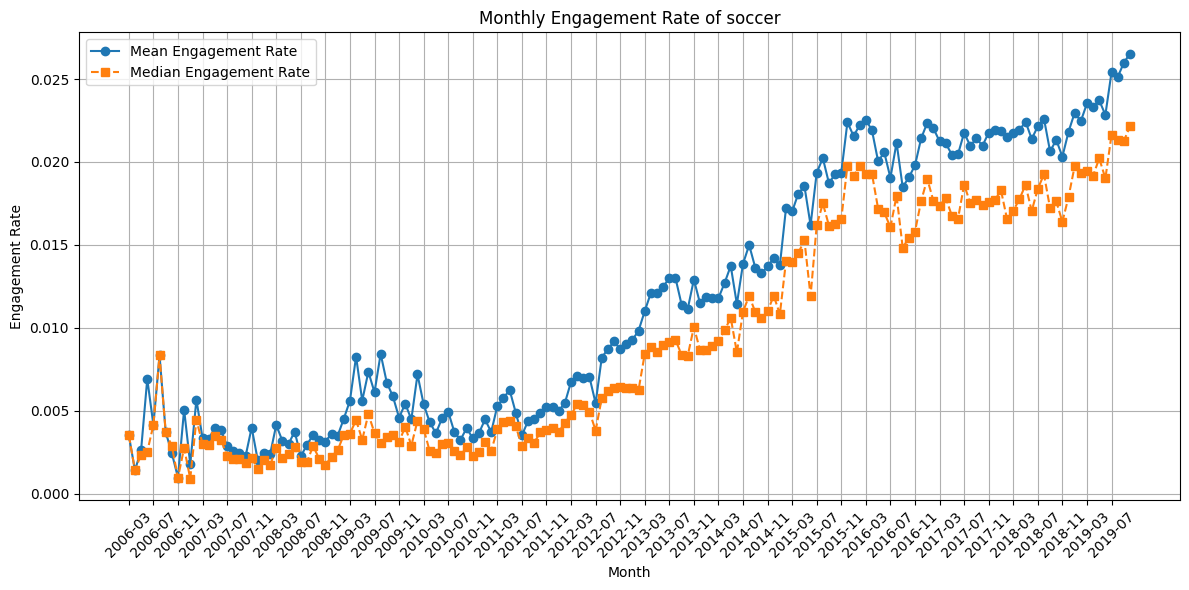

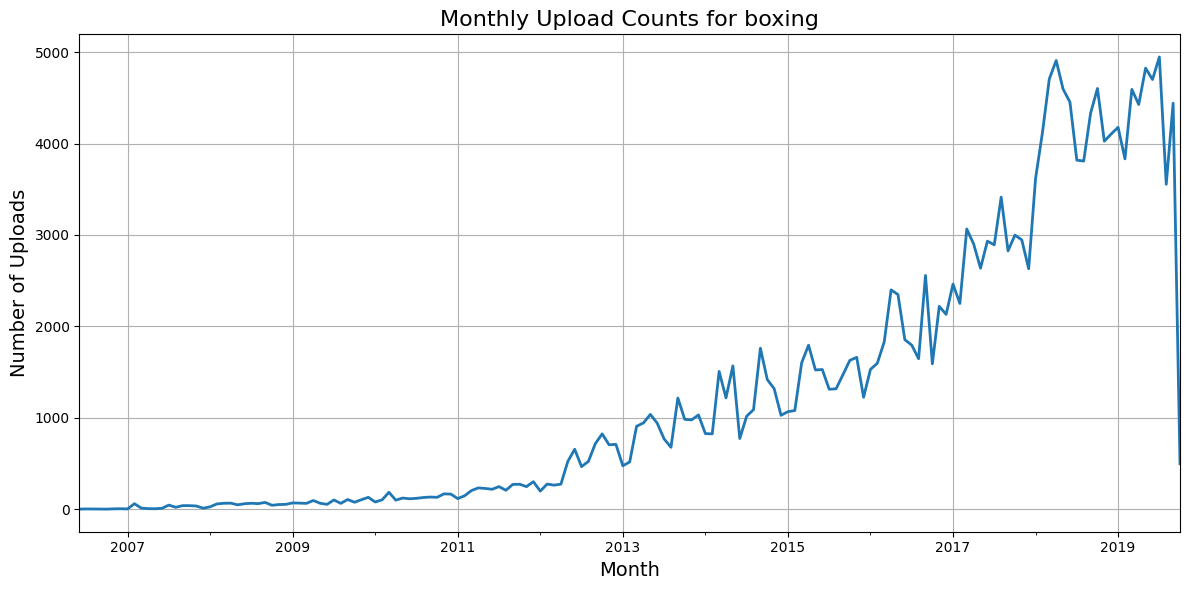

Autocorrelation:  0.9549657005302191
periodic analysis
len 159
[159.    79.5   53.    39.75  31.8   26.5 ]
[782.15841517 422.06772085 321.51016339 197.73309869 146.5130009
 109.68757354]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


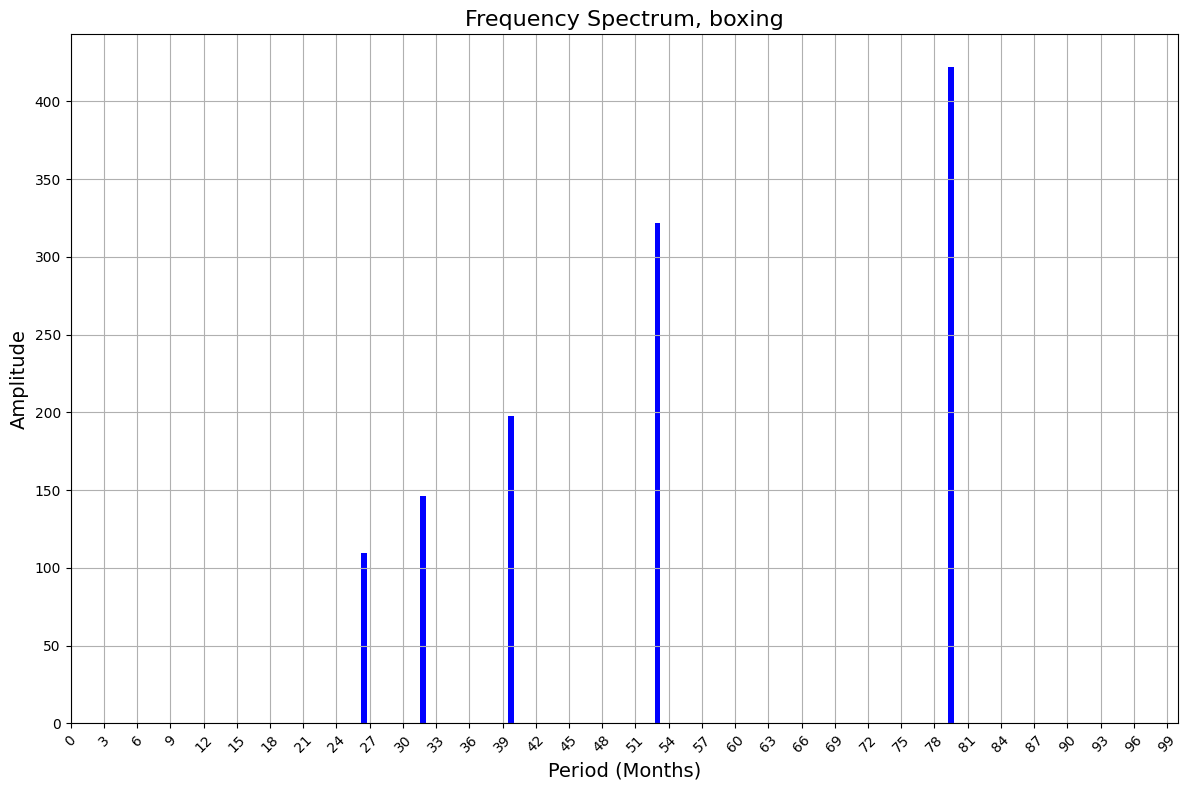

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


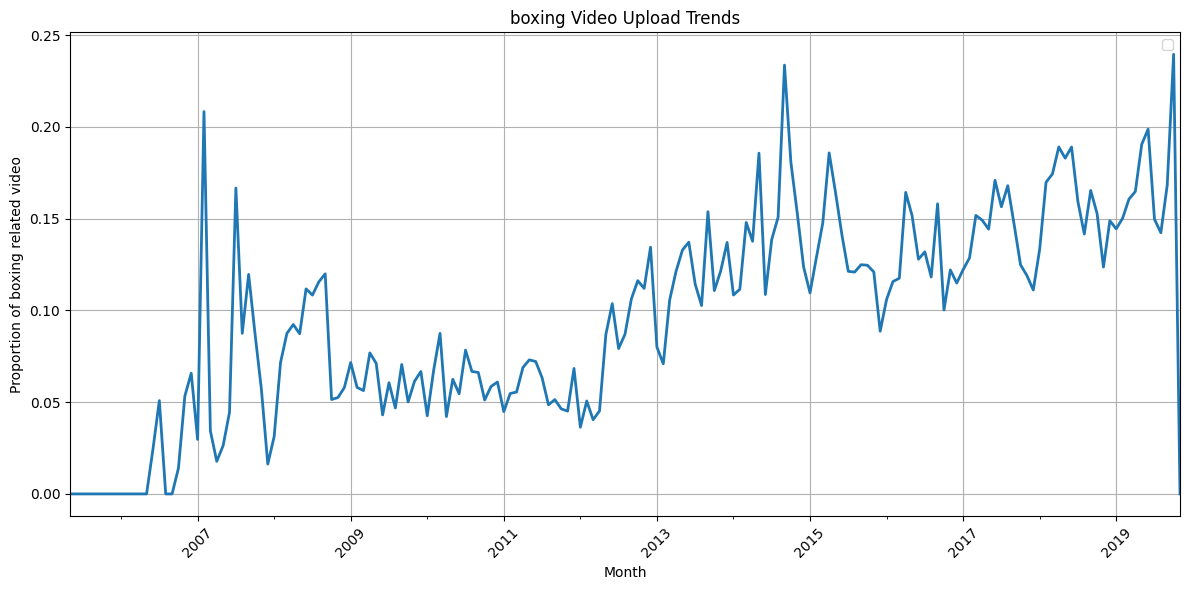

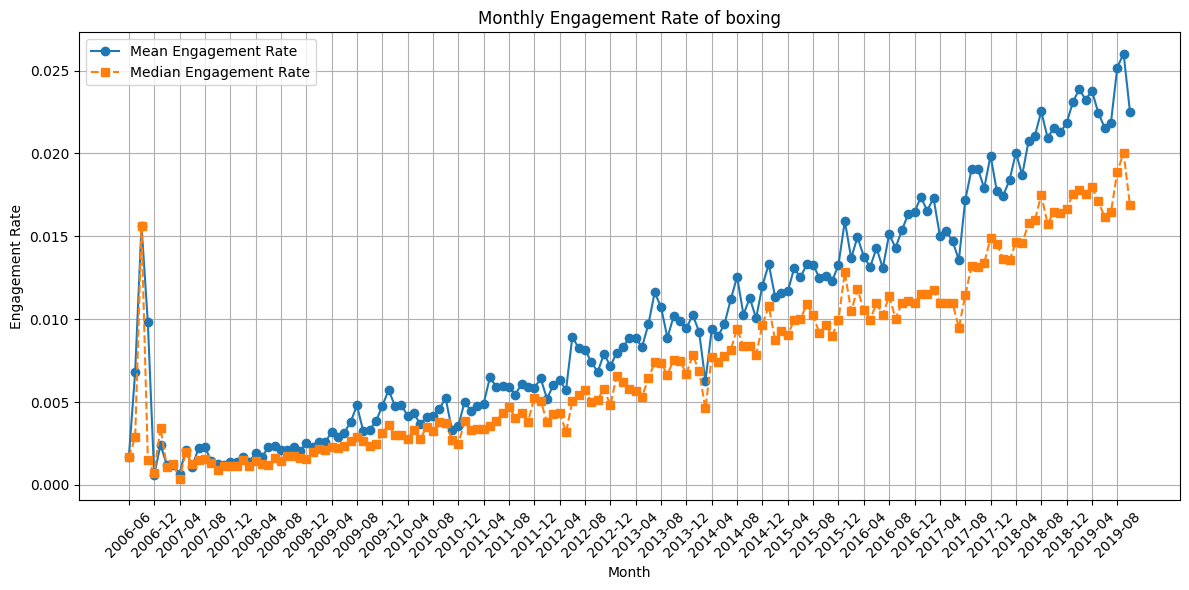

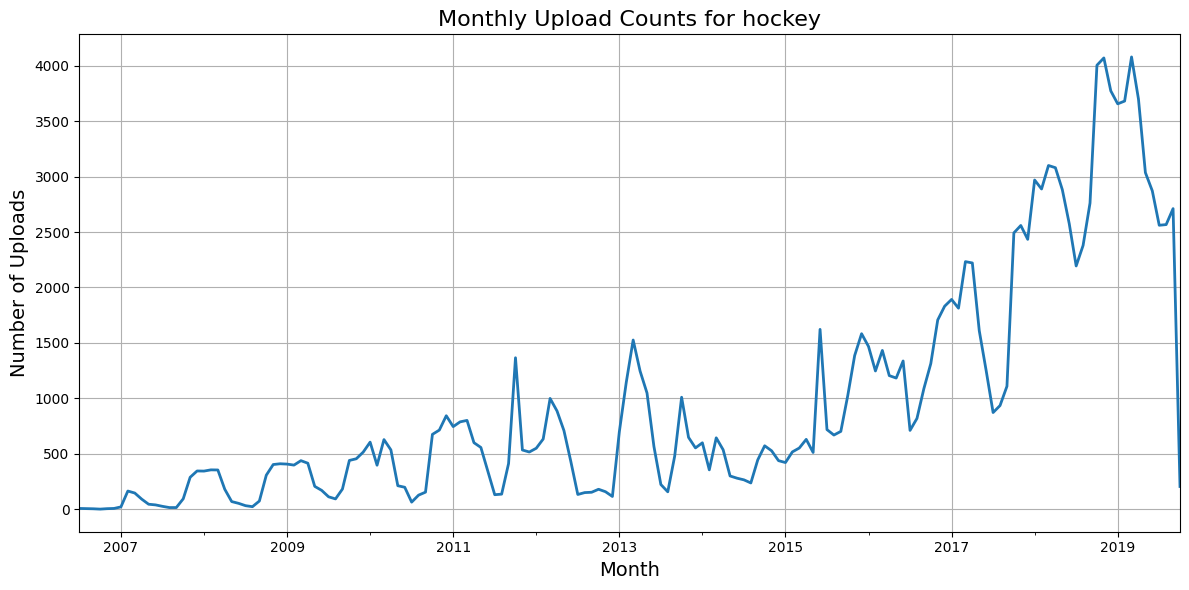

Autocorrelation:  0.9374096807813097
periodic analysis
len 159
[159.          79.5         53.          39.75        31.8
  22.71428571  14.45454545  12.23076923]
[444.07578708 361.24872578 205.25004626 181.26495208 171.44210111
 102.15718967 100.70089197 121.32448079]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


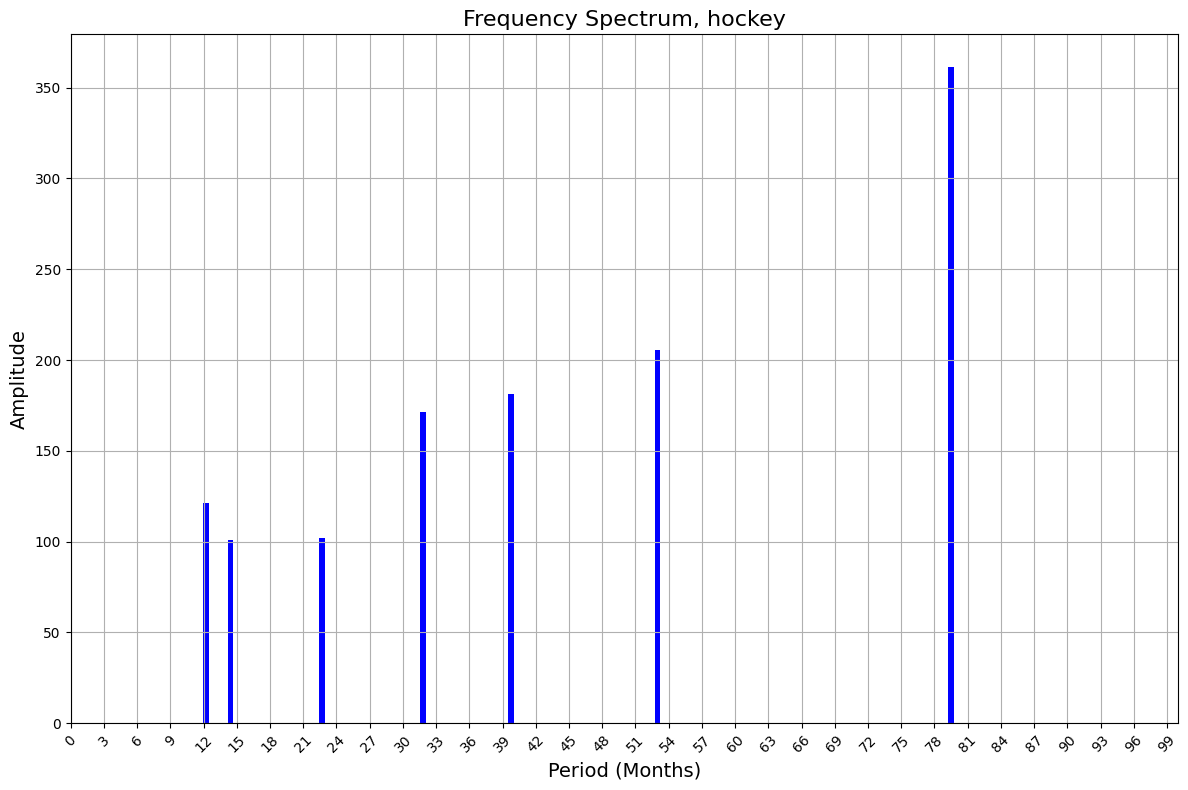

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


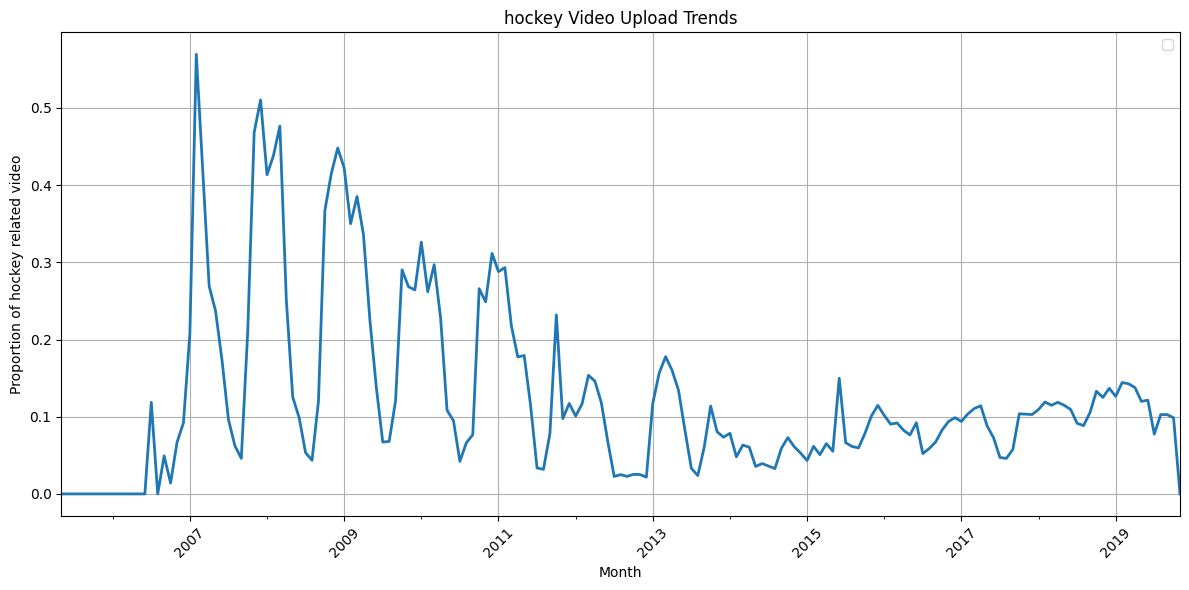

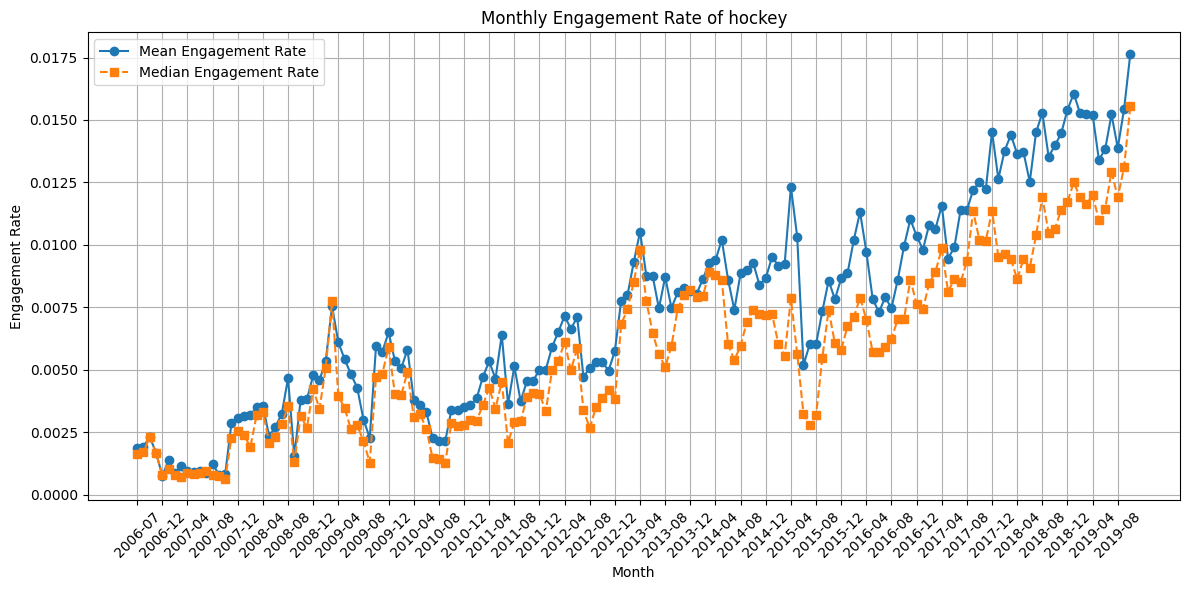

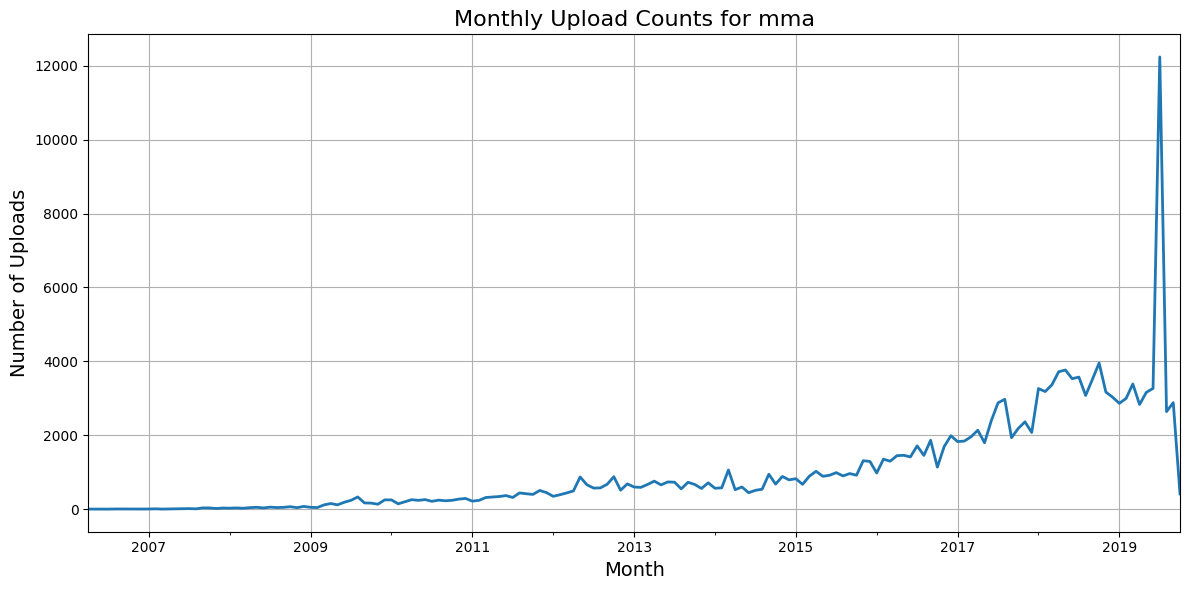

Autocorrelation:  0.6957468521016212
periodic analysis
len 161
[161.          80.5         53.66666667  40.25        32.2
  26.83333333  14.63636364  13.41666667  12.38461538]
[585.36629253 408.5037948  244.08594893 178.53251996 121.76501413
 100.50486838 105.31876178 122.01903751 110.09234667]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


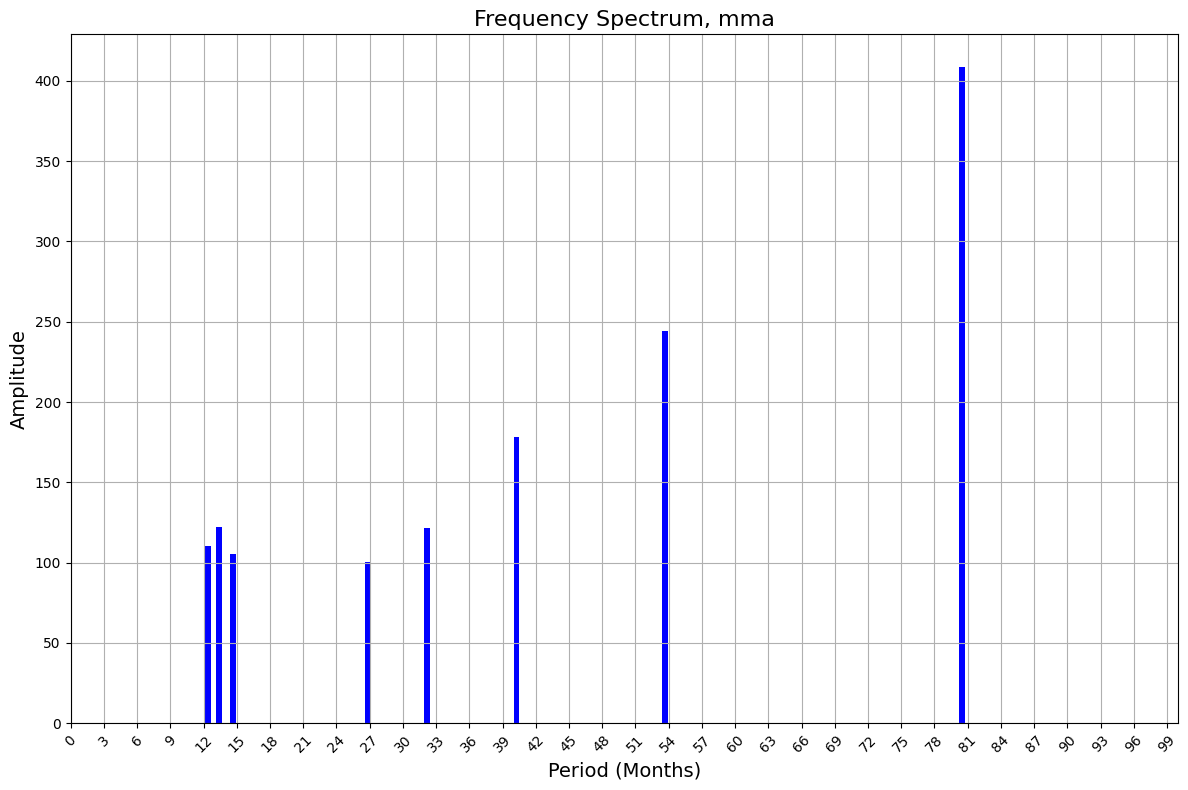

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


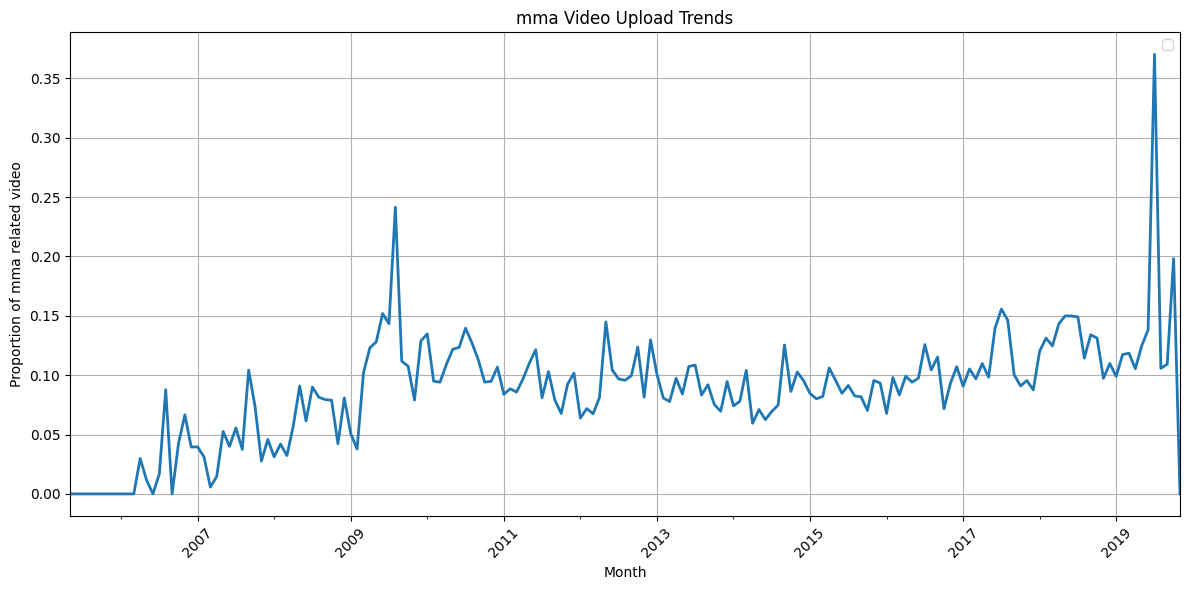

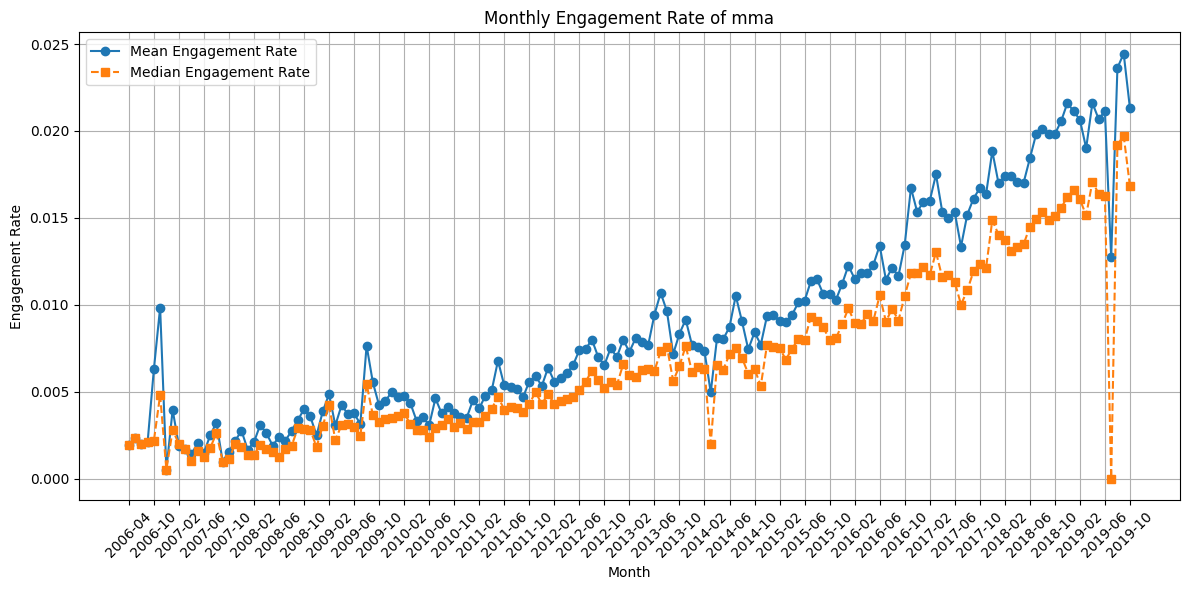

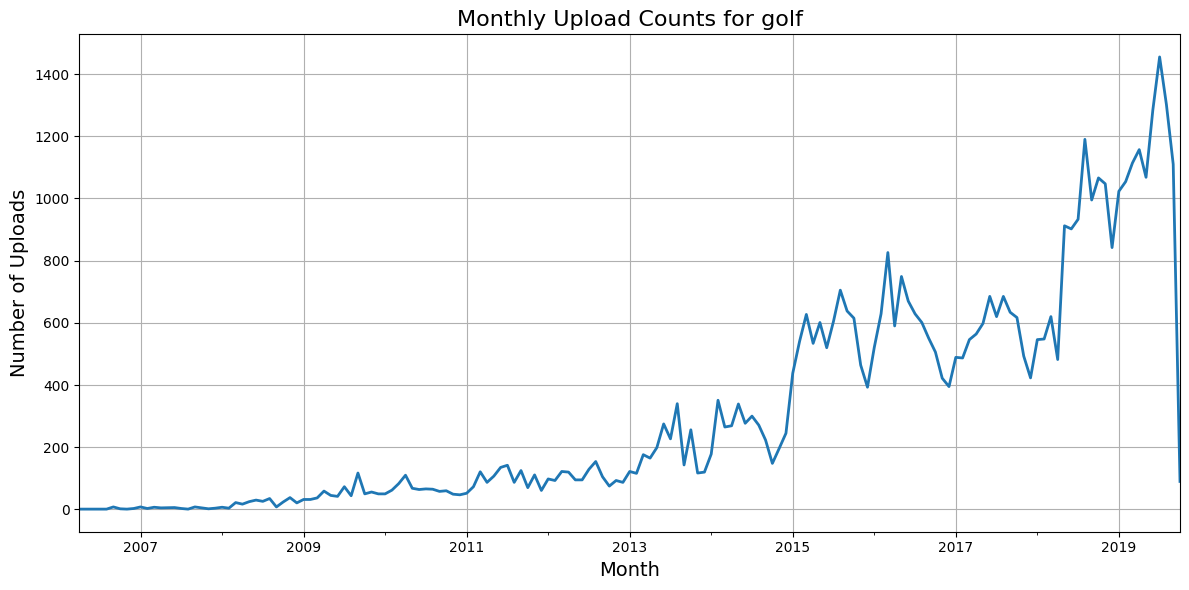

Autocorrelation:  0.94377202563214
periodic analysis
len 159
[159.]
[179.53976241]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


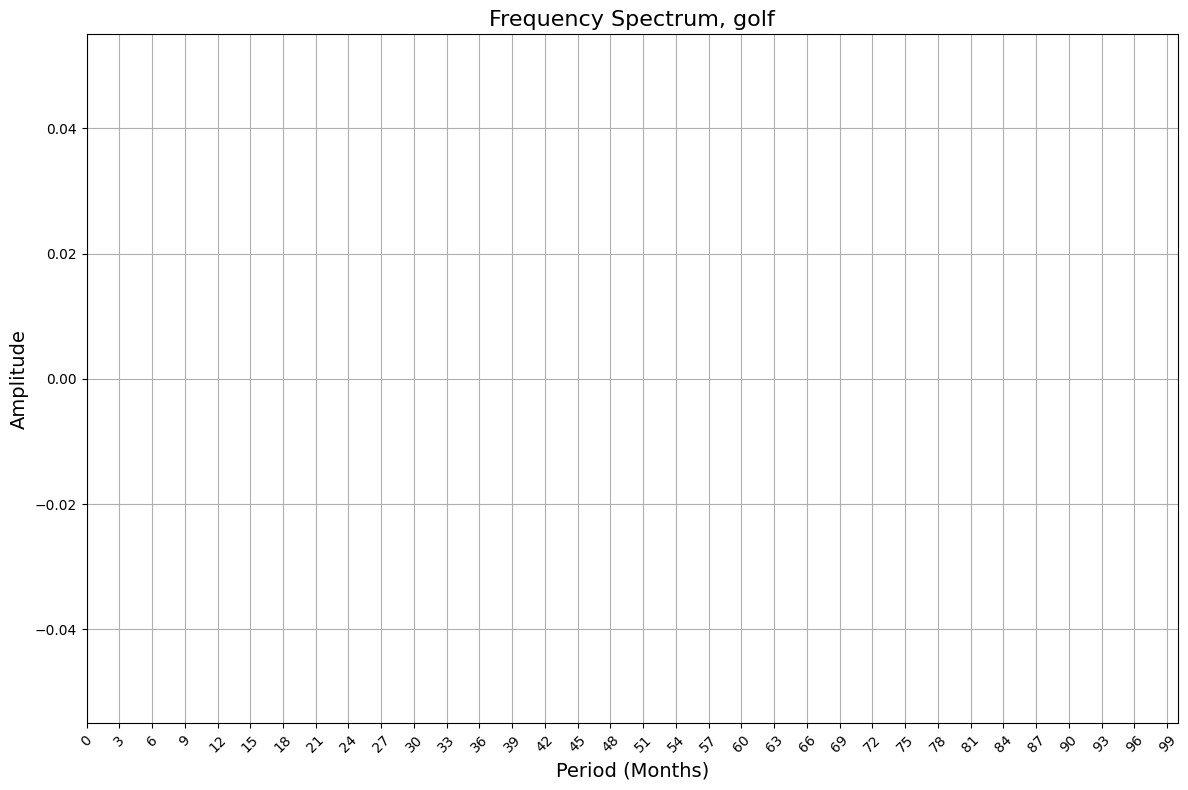

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


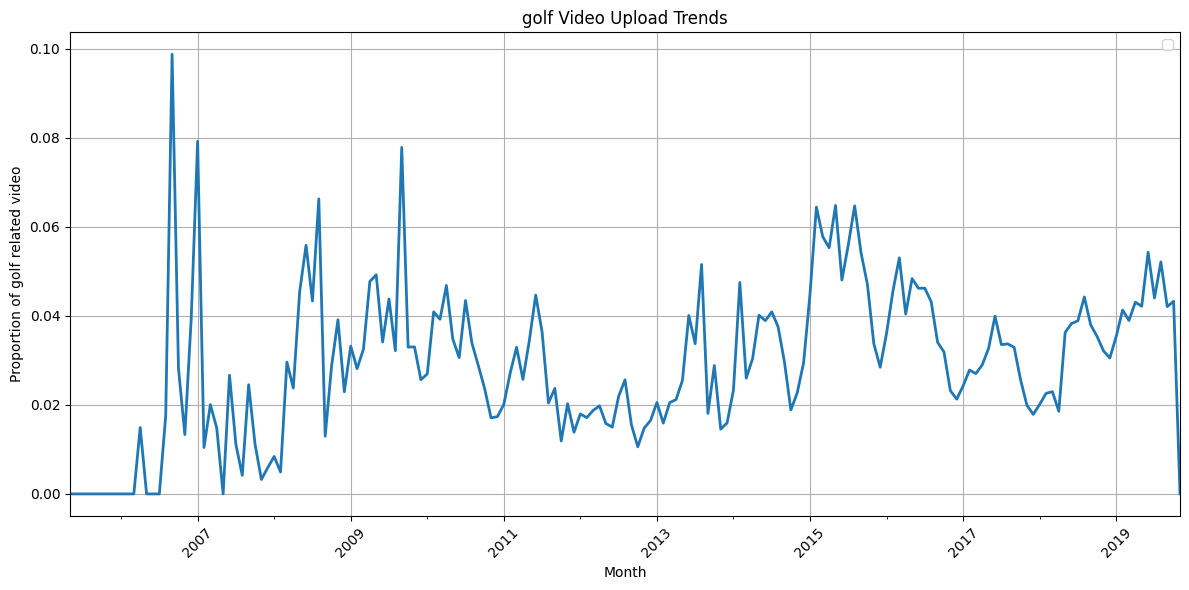

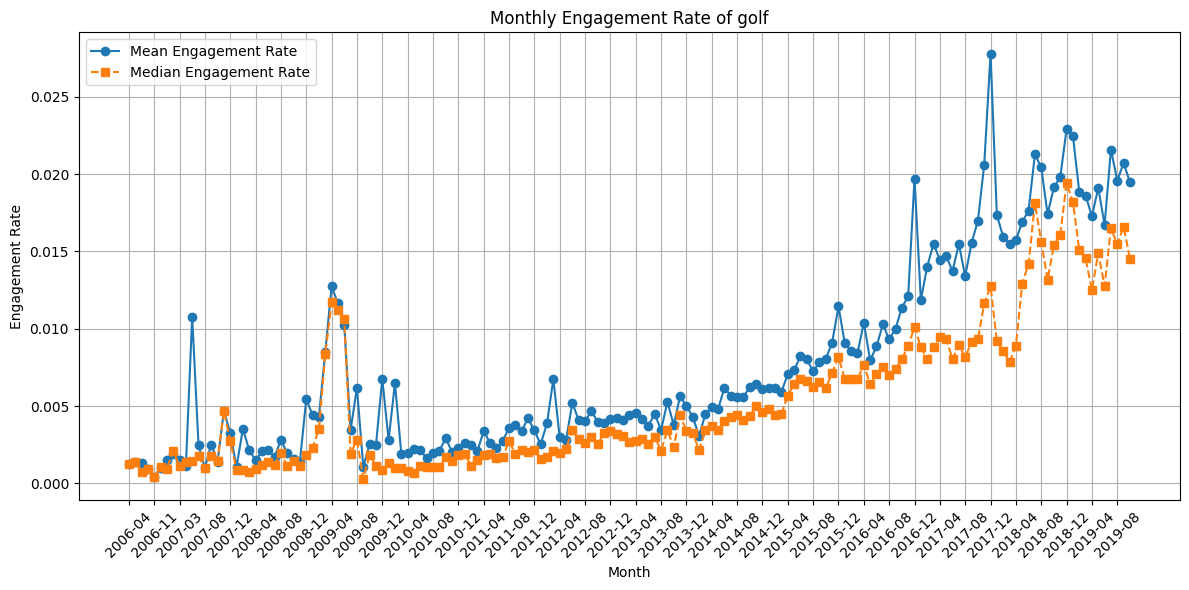

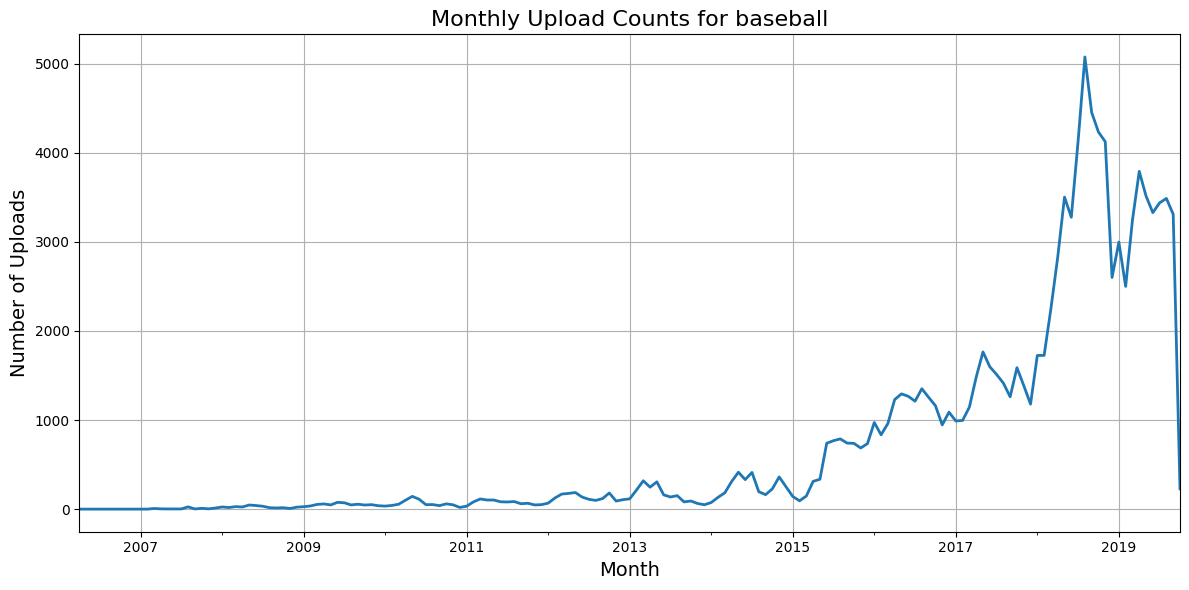

Autocorrelation:  0.9561795613632937
periodic analysis
len 157
[157.          78.5         52.33333333  39.25        31.4
  26.16666667  12.07692308]
[544.68349526 360.4790264  244.98688464 225.14835125 183.40102977
 118.0589866  115.78961238]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


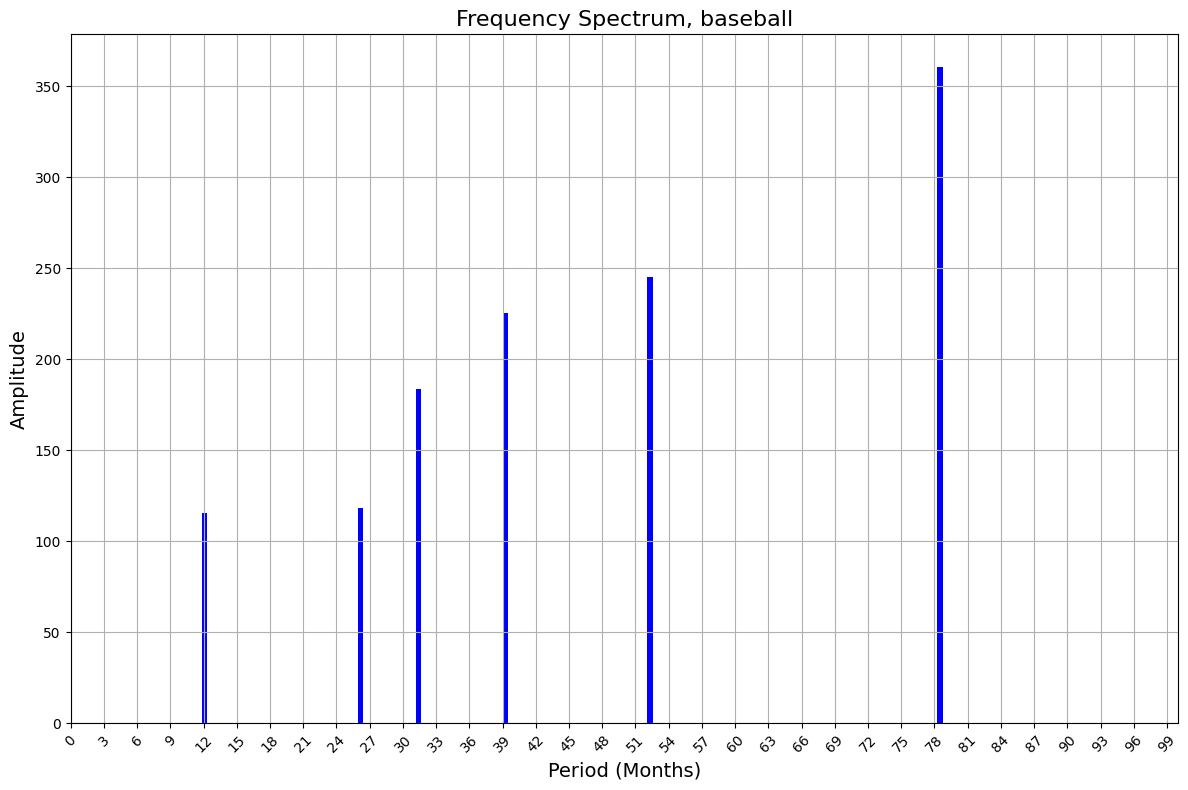

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


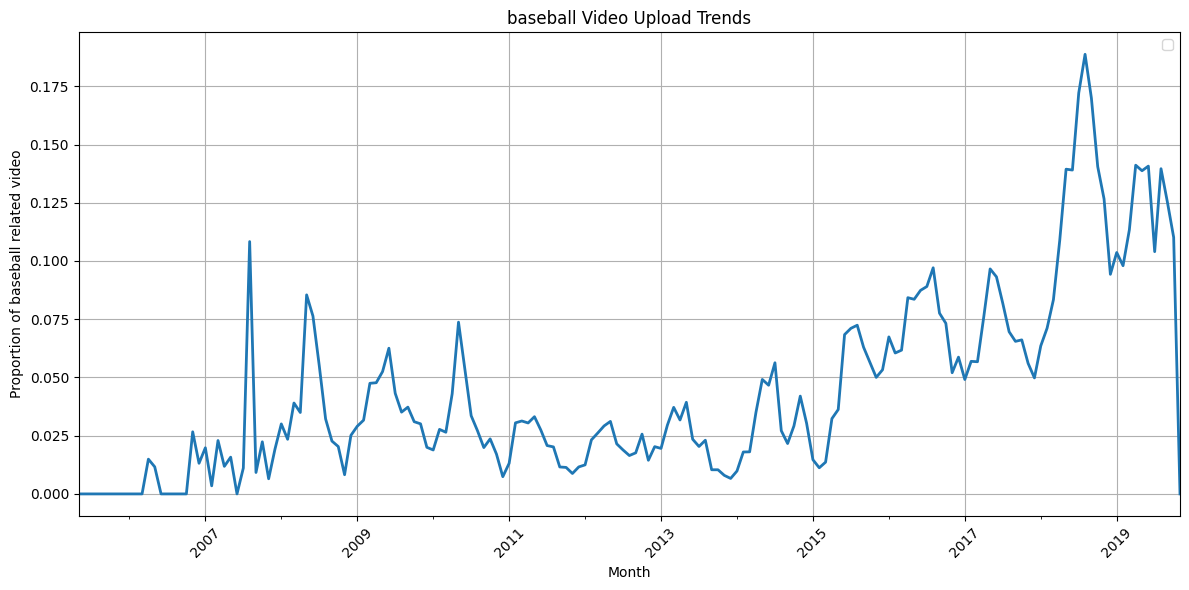

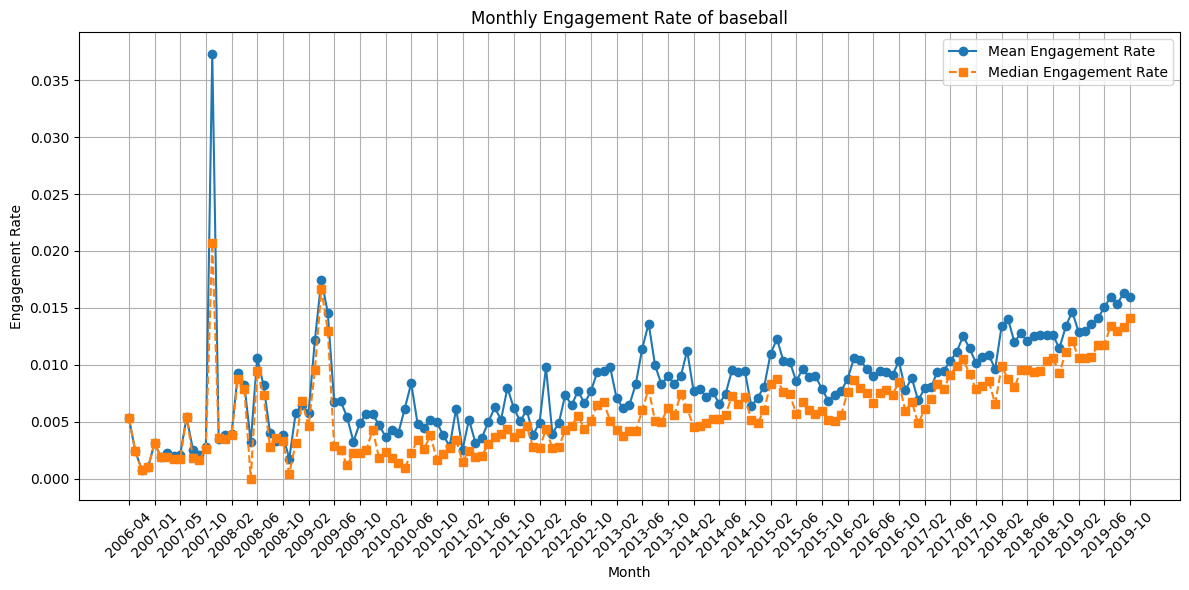

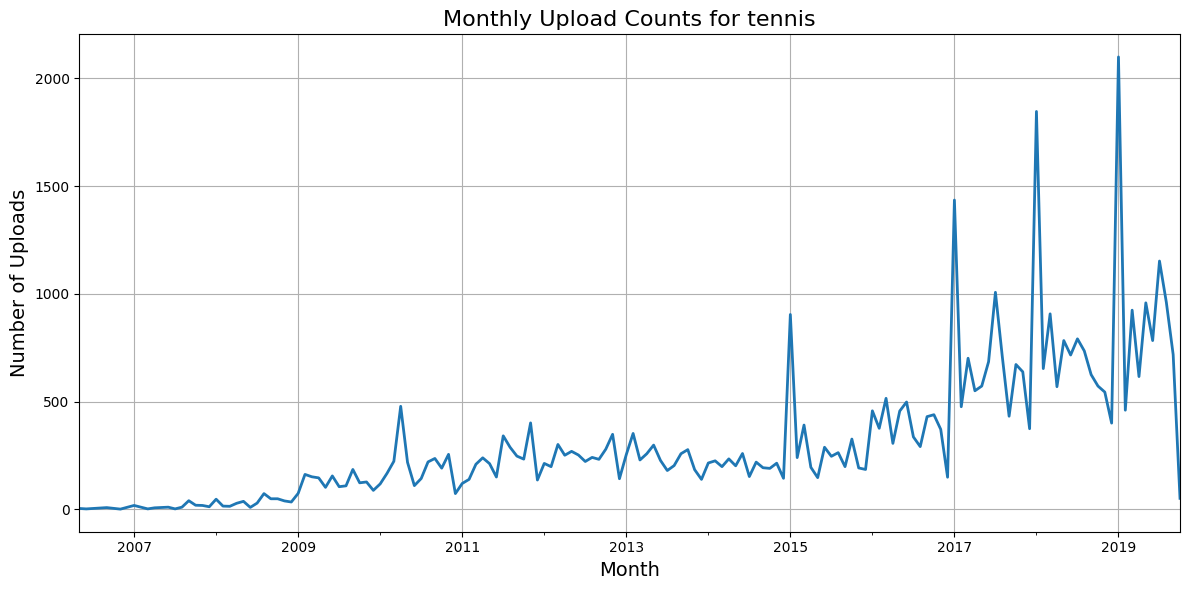

Autocorrelation:  0.5190318448201308
periodic analysis
len 157
[157.   78.5]
[118.68631341 106.27335114]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


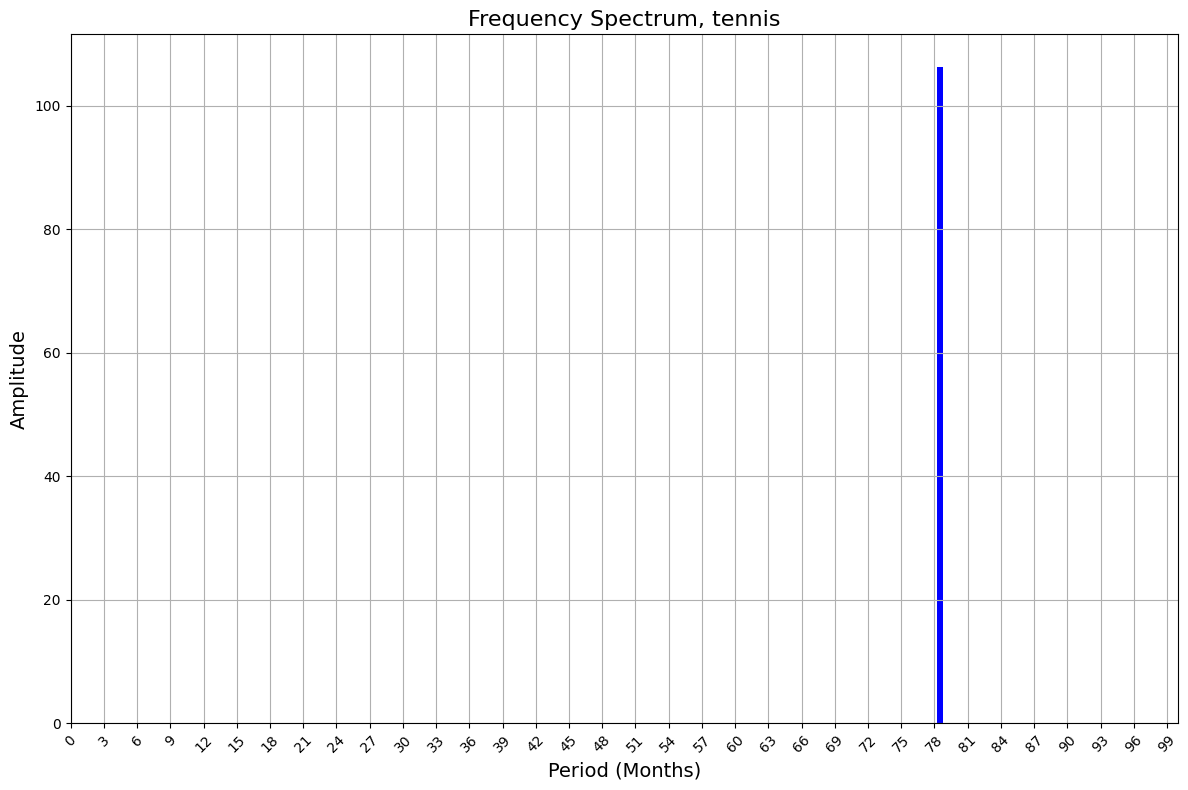

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


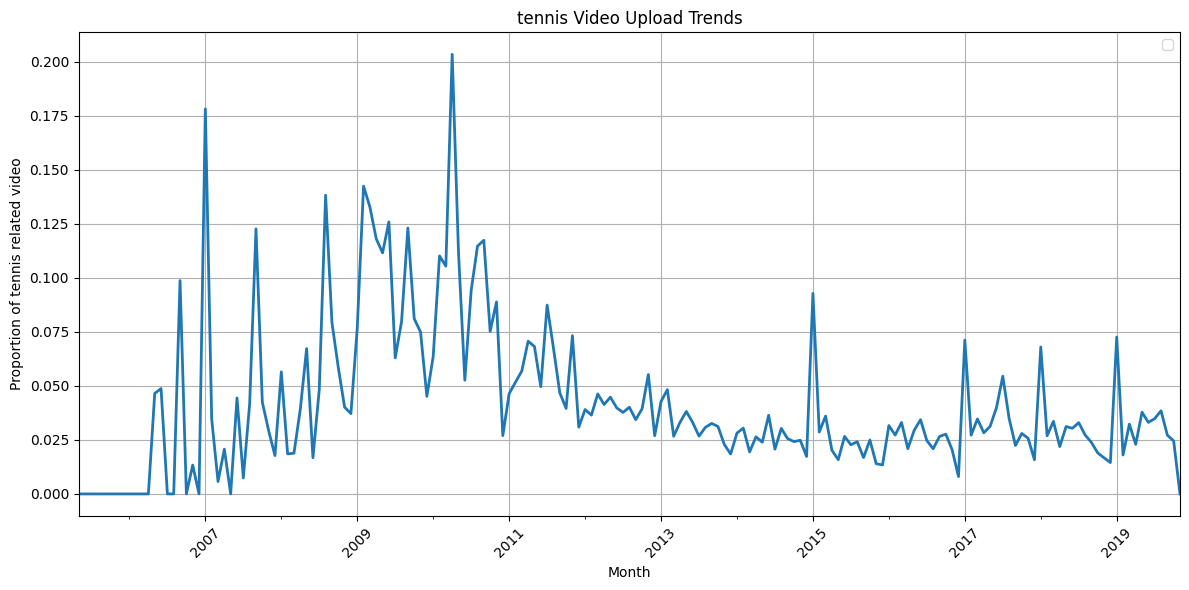

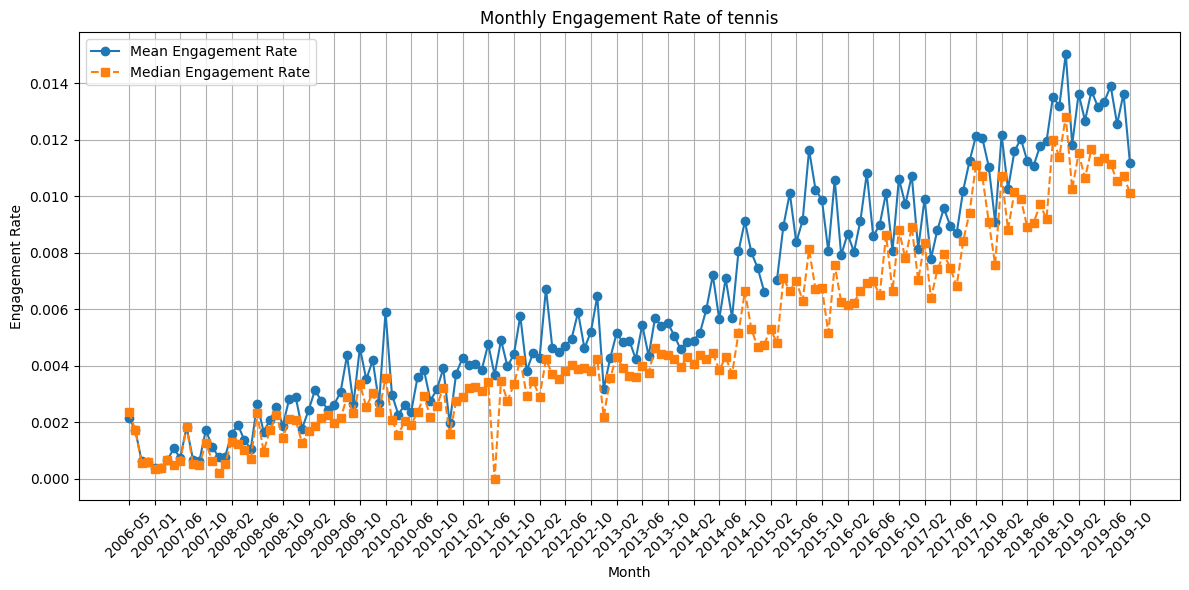

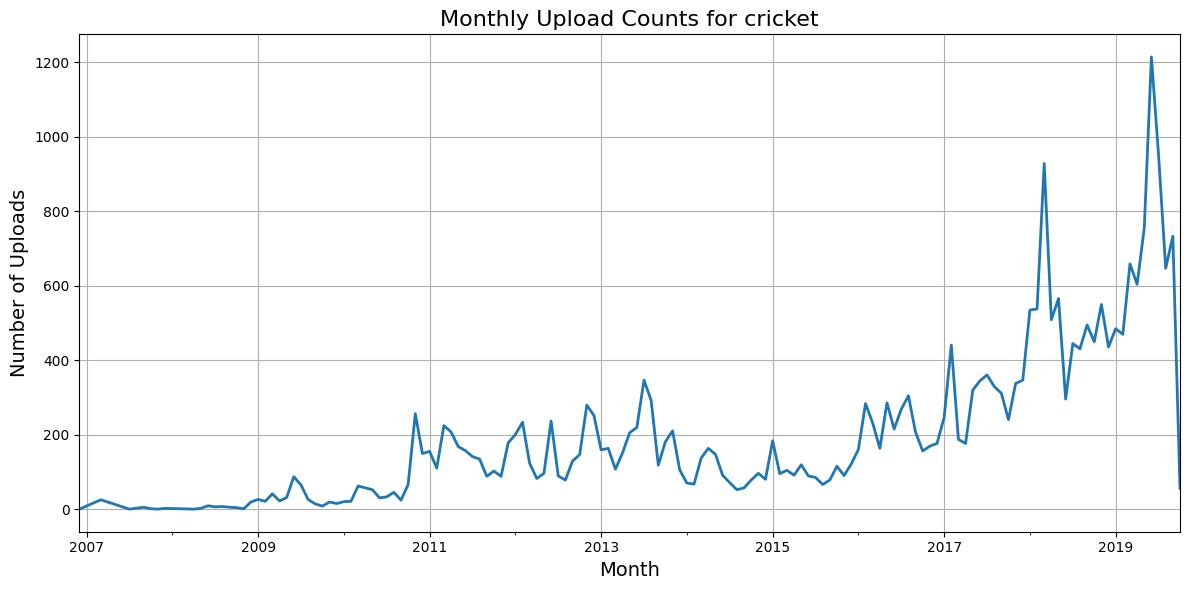

Autocorrelation:  0.8492979843502197
periodic analysis
len 146
[]
[]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


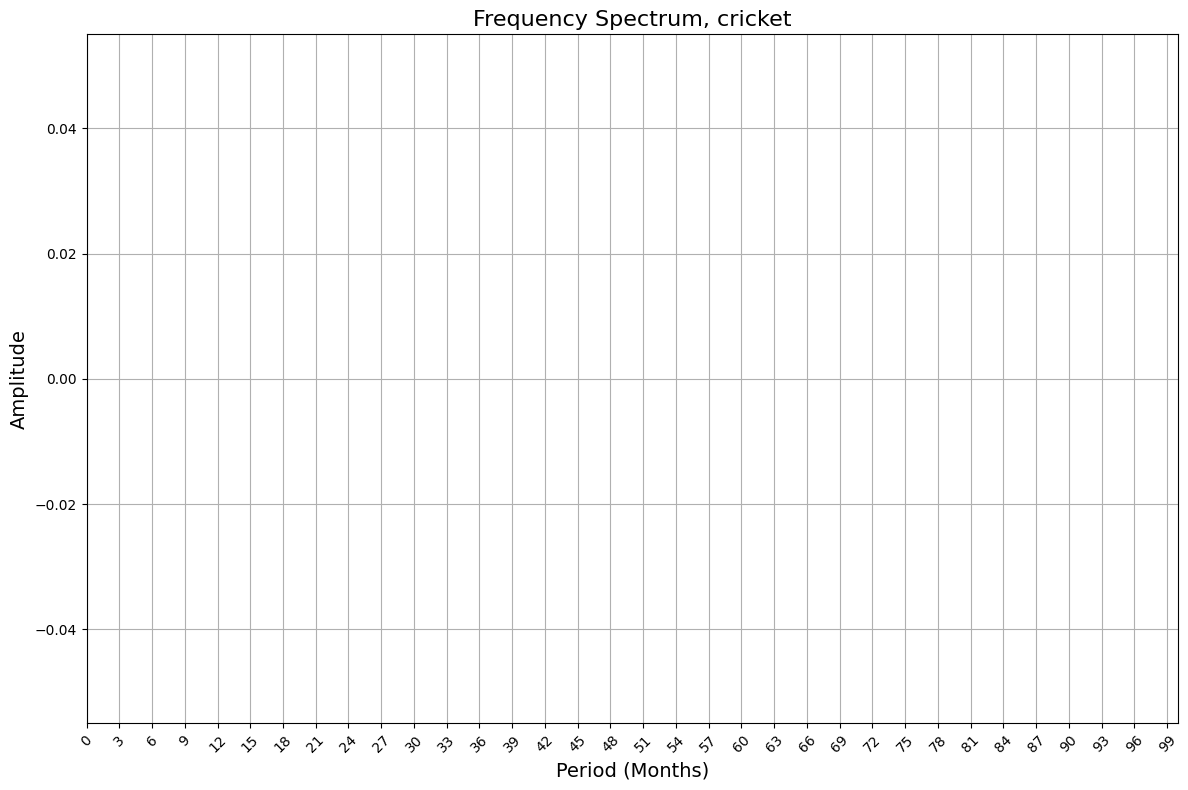

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


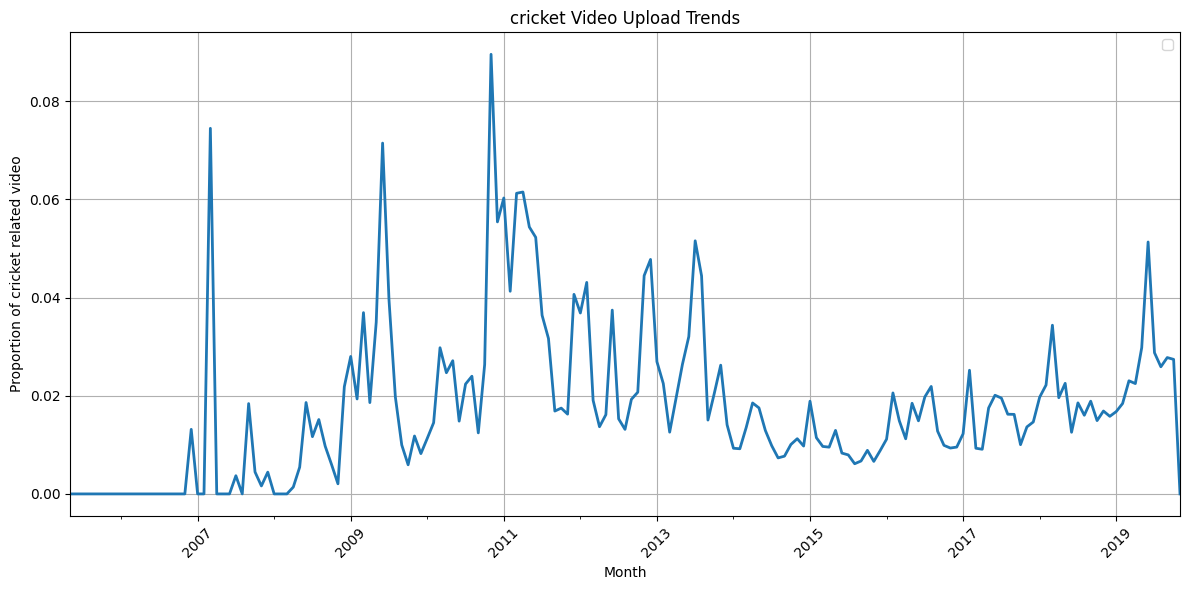

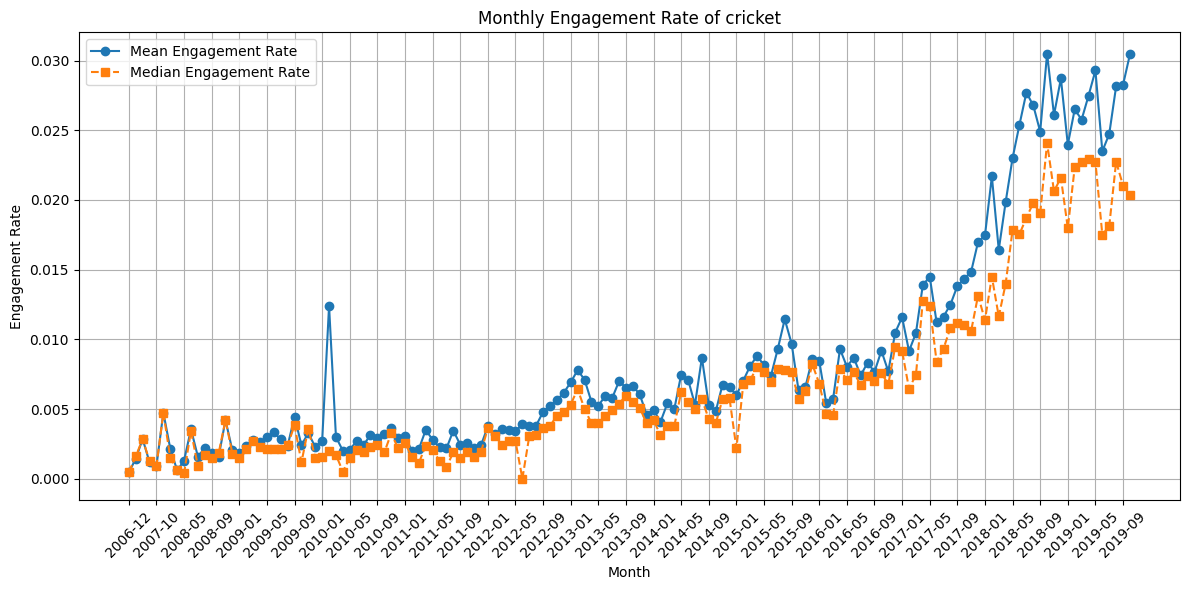

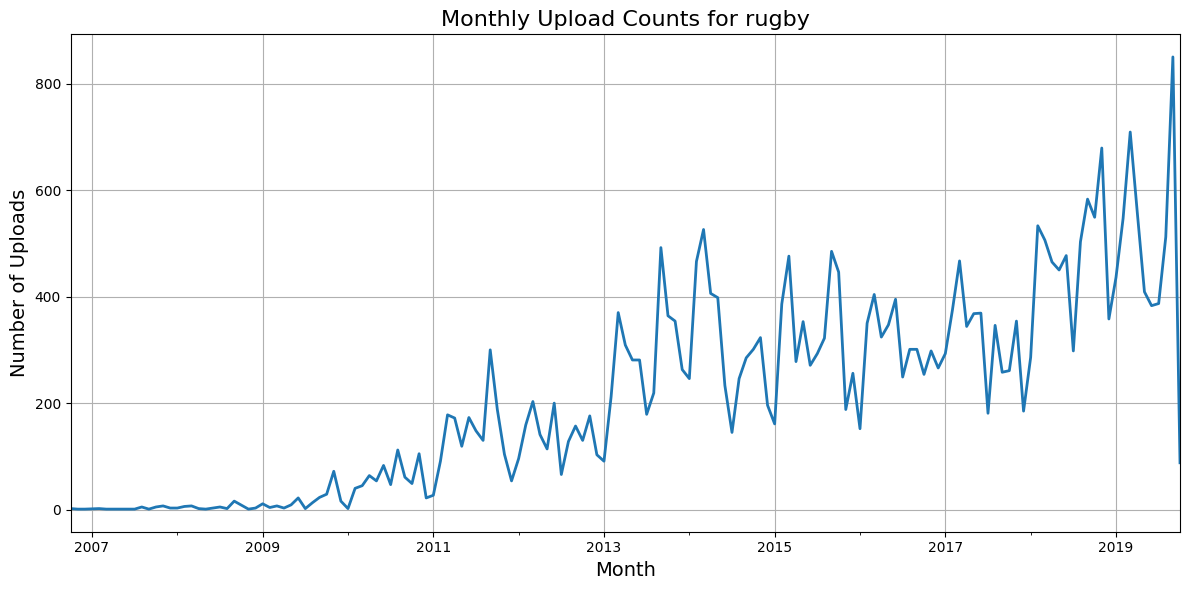

Autocorrelation:  0.811127487057154
periodic analysis
len 154
[]
[]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


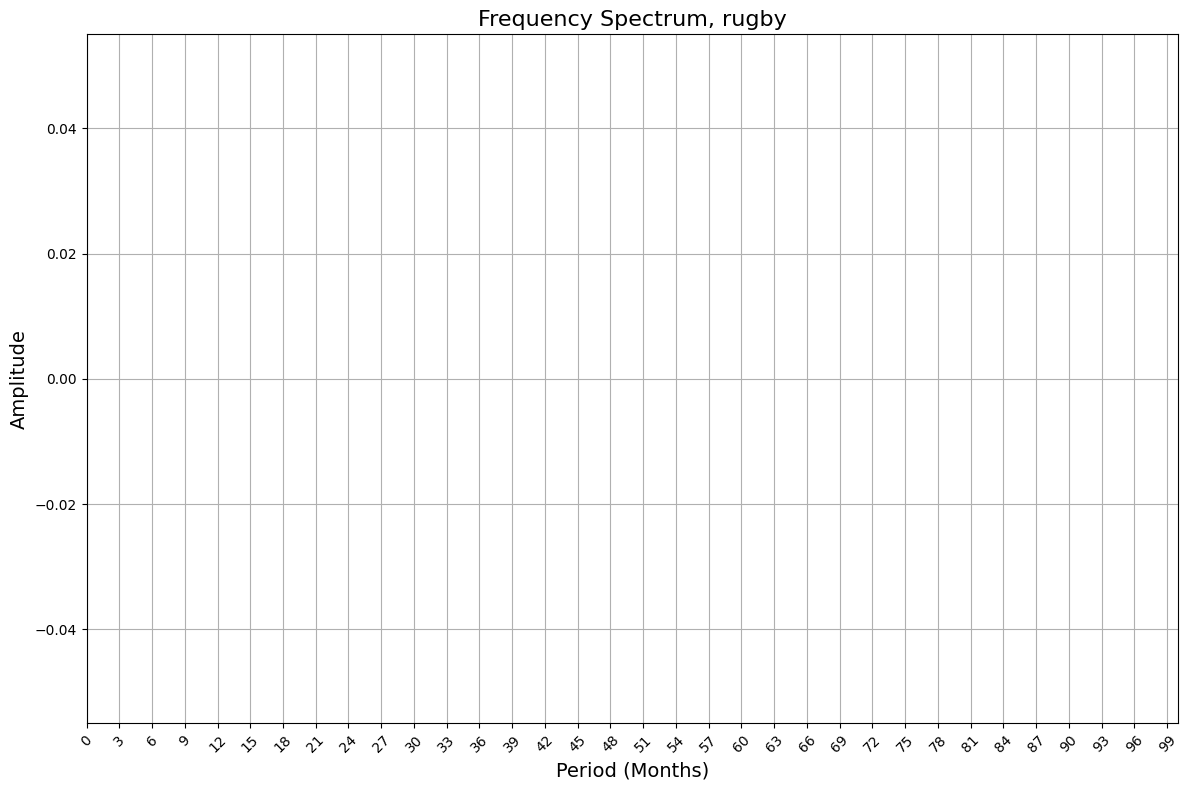

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


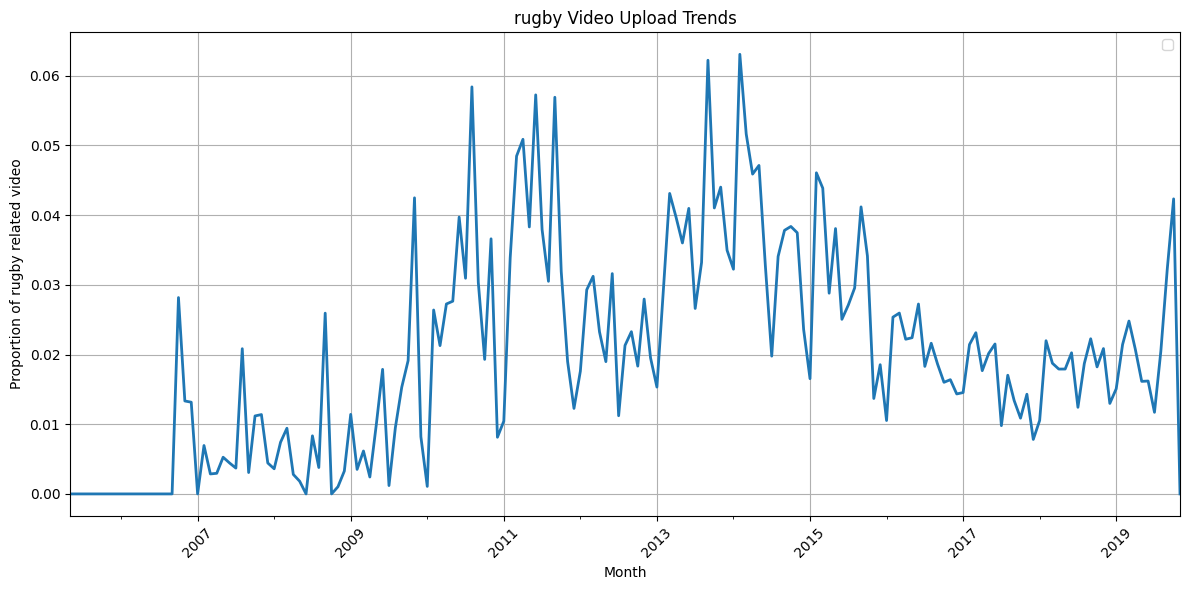

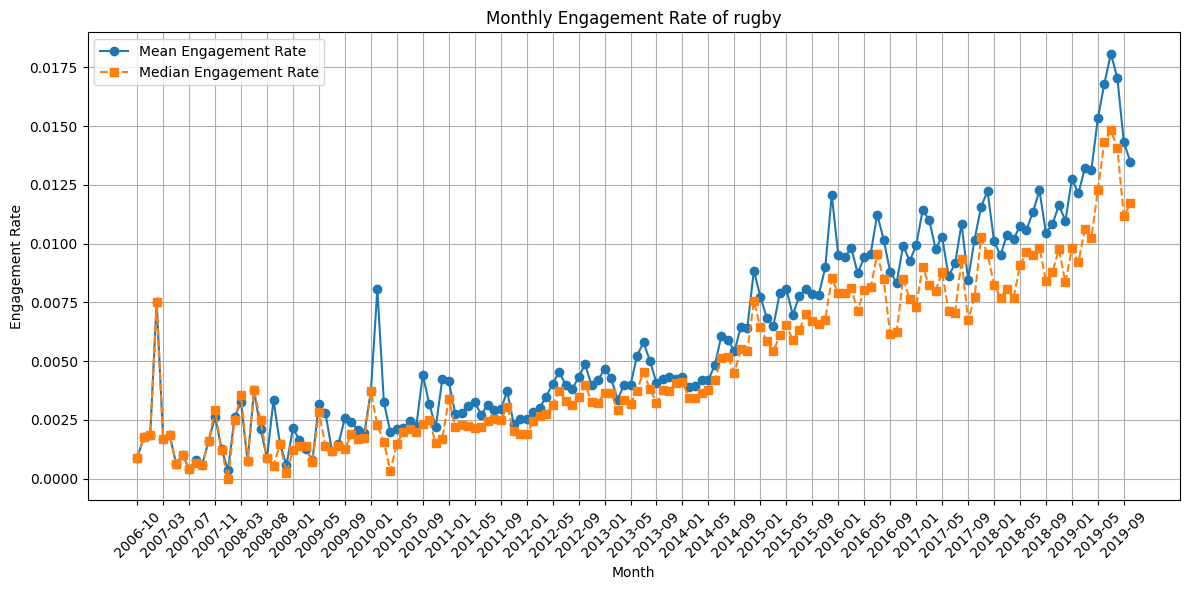

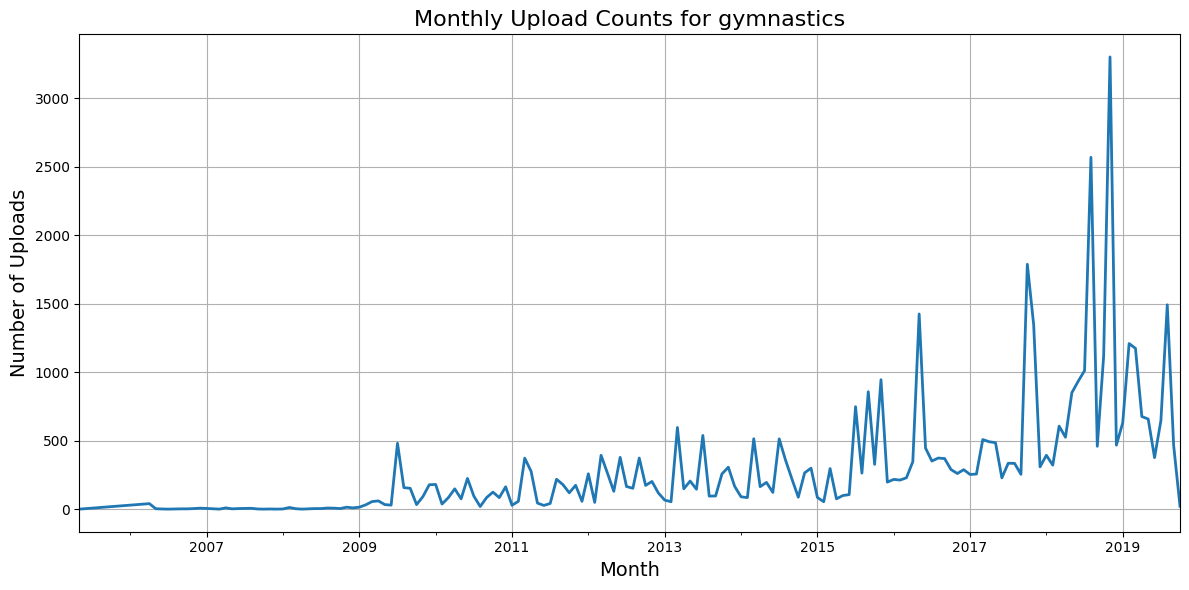

Autocorrelation:  0.4541314861912214
periodic analysis
len 163
[163.   81.5]
[141.95853242 107.69158495]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


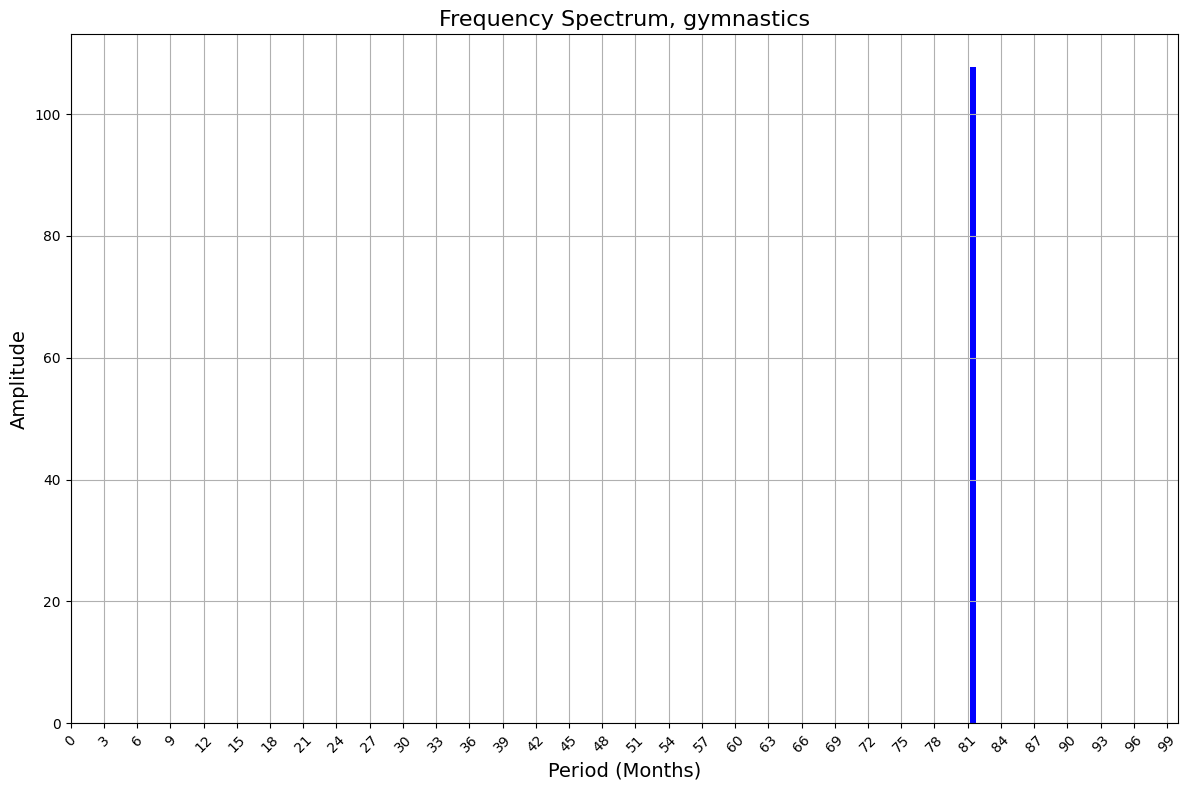

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


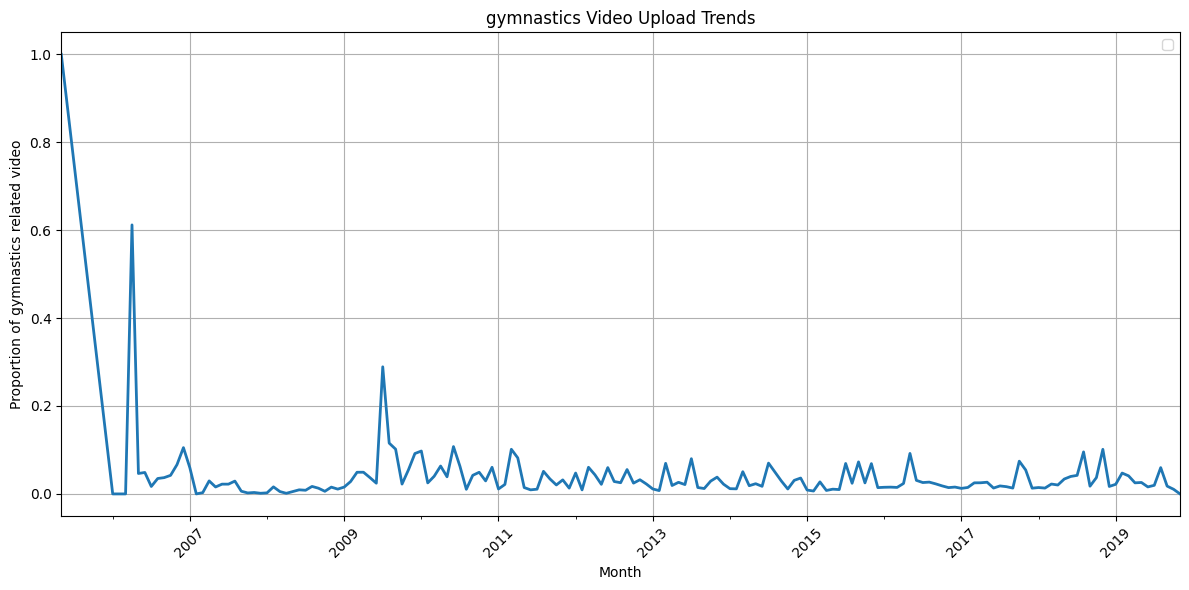

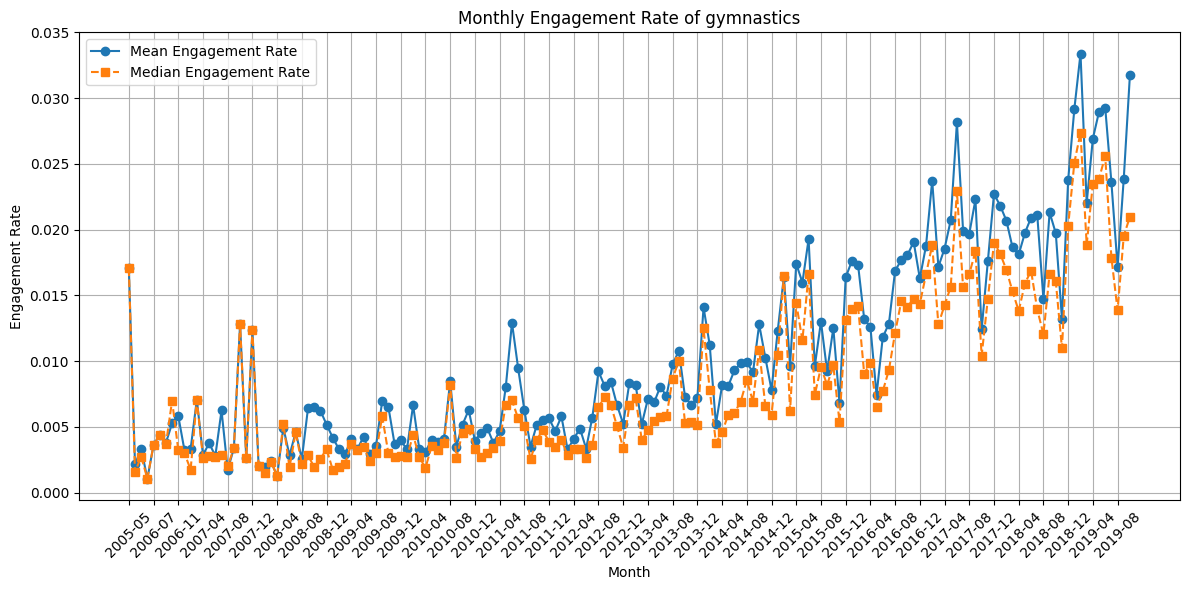

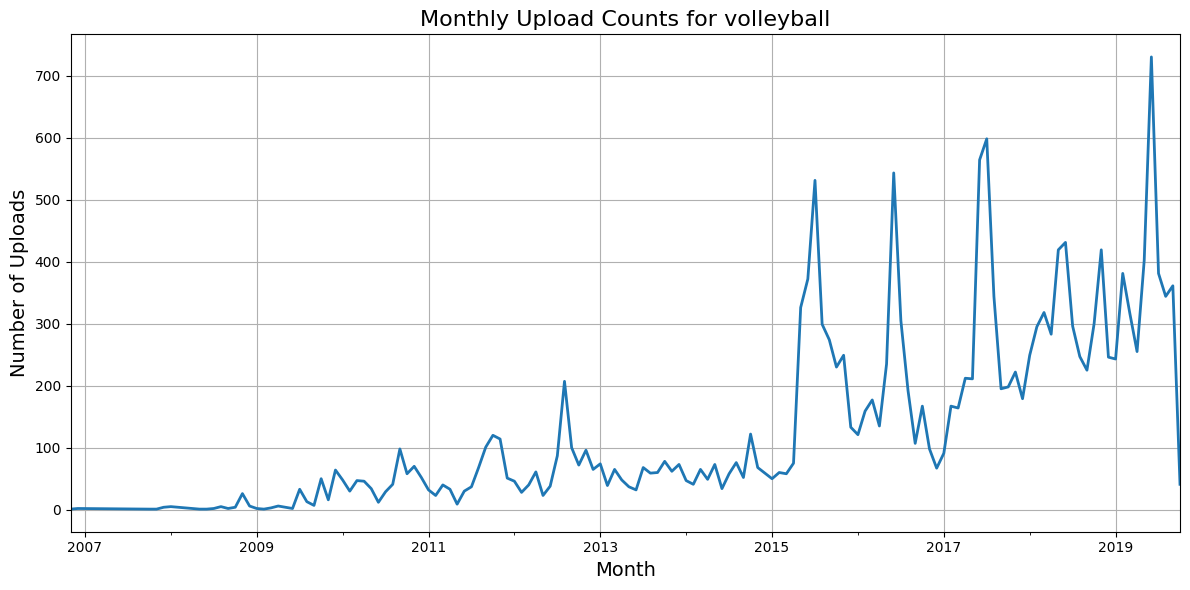

Autocorrelation:  0.8129346018295002
periodic analysis
len 147
[]
[]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


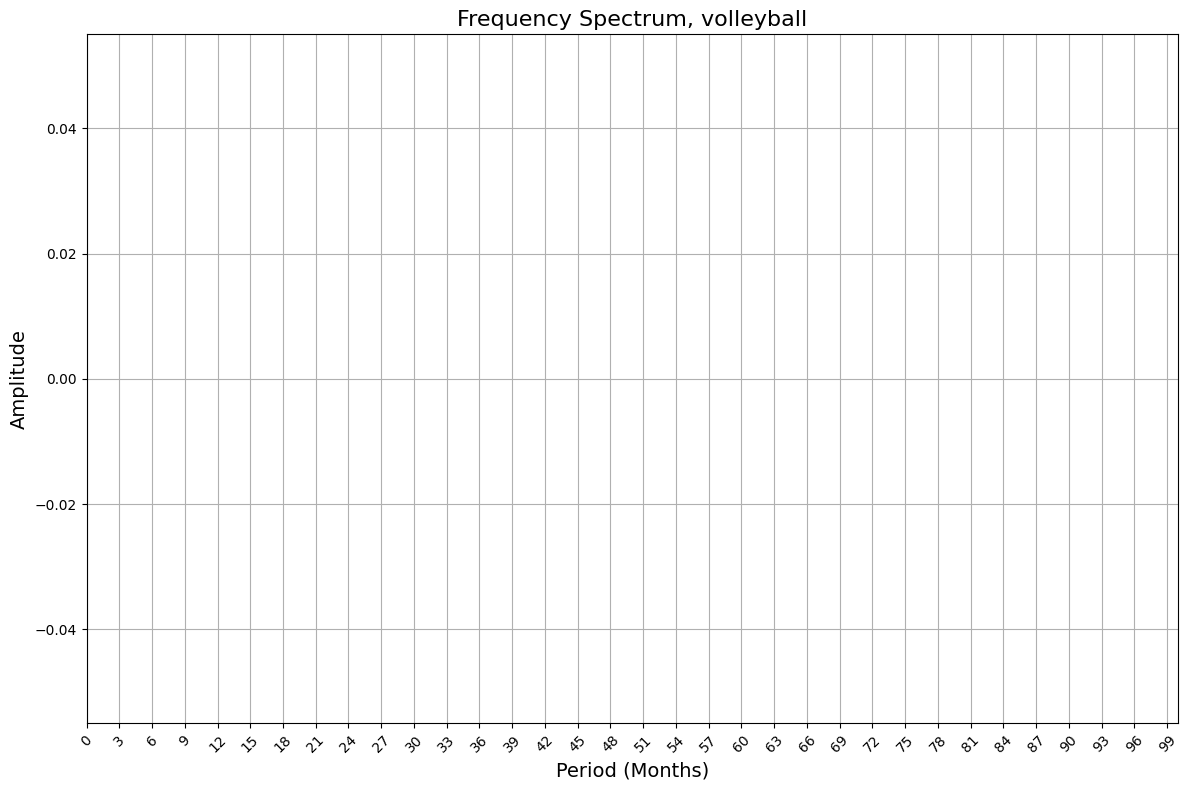

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


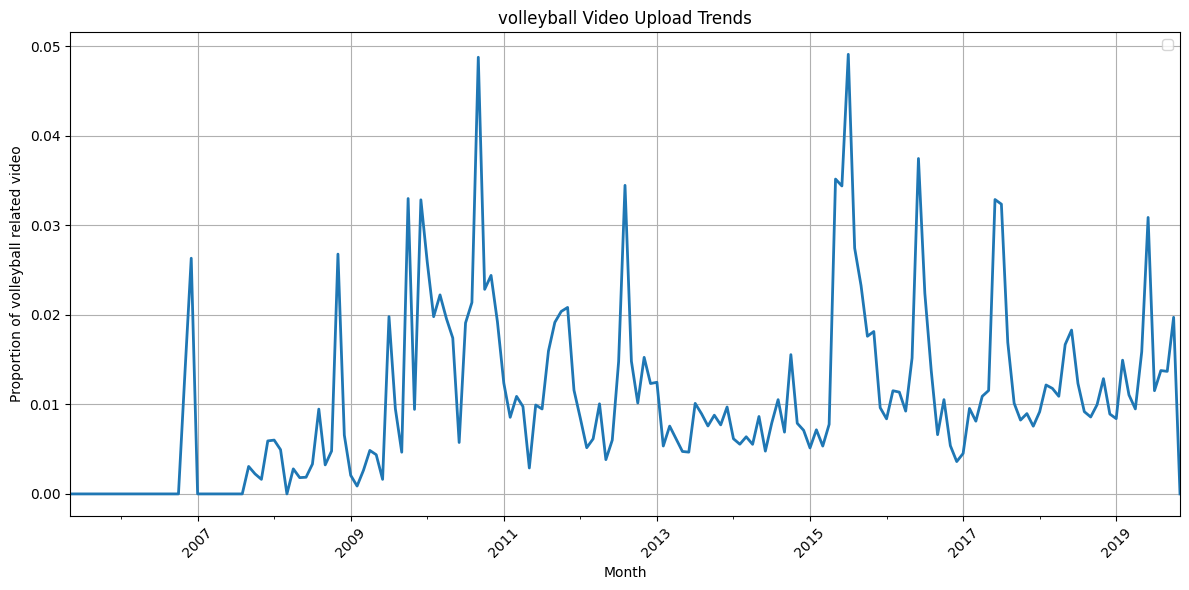

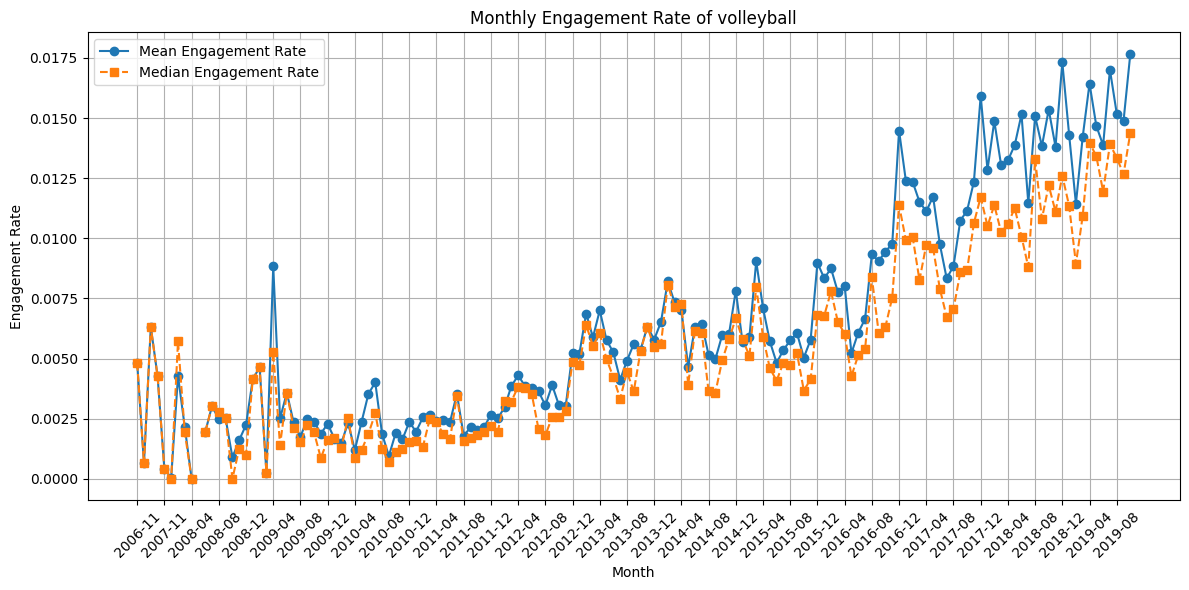

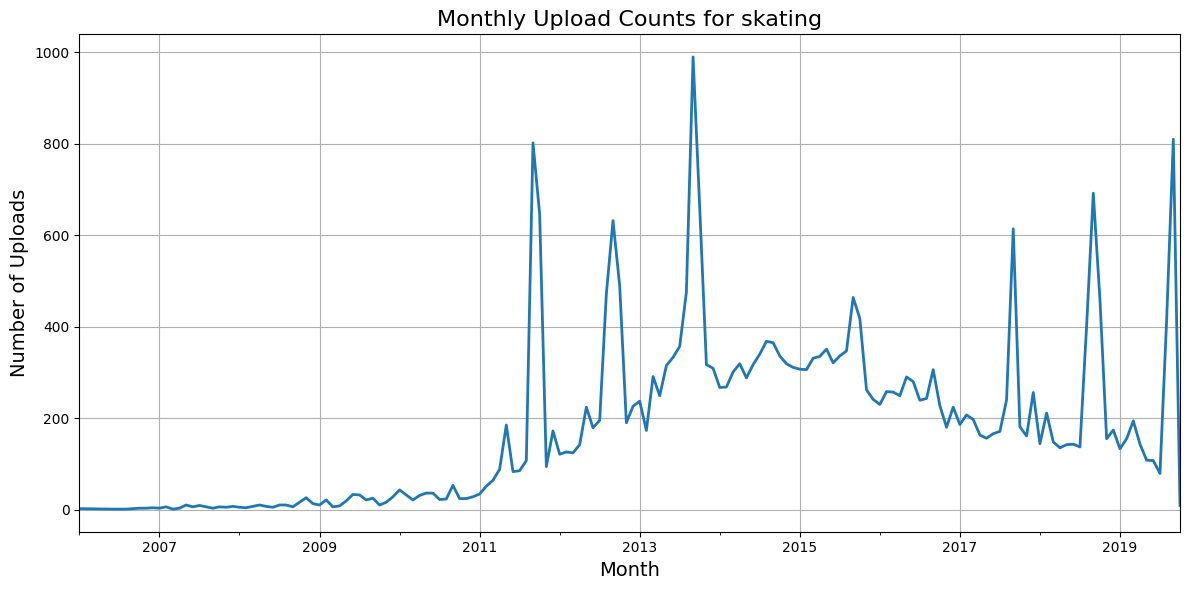

Autocorrelation:  0.697705383188075
periodic analysis
len 160
[]
[]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


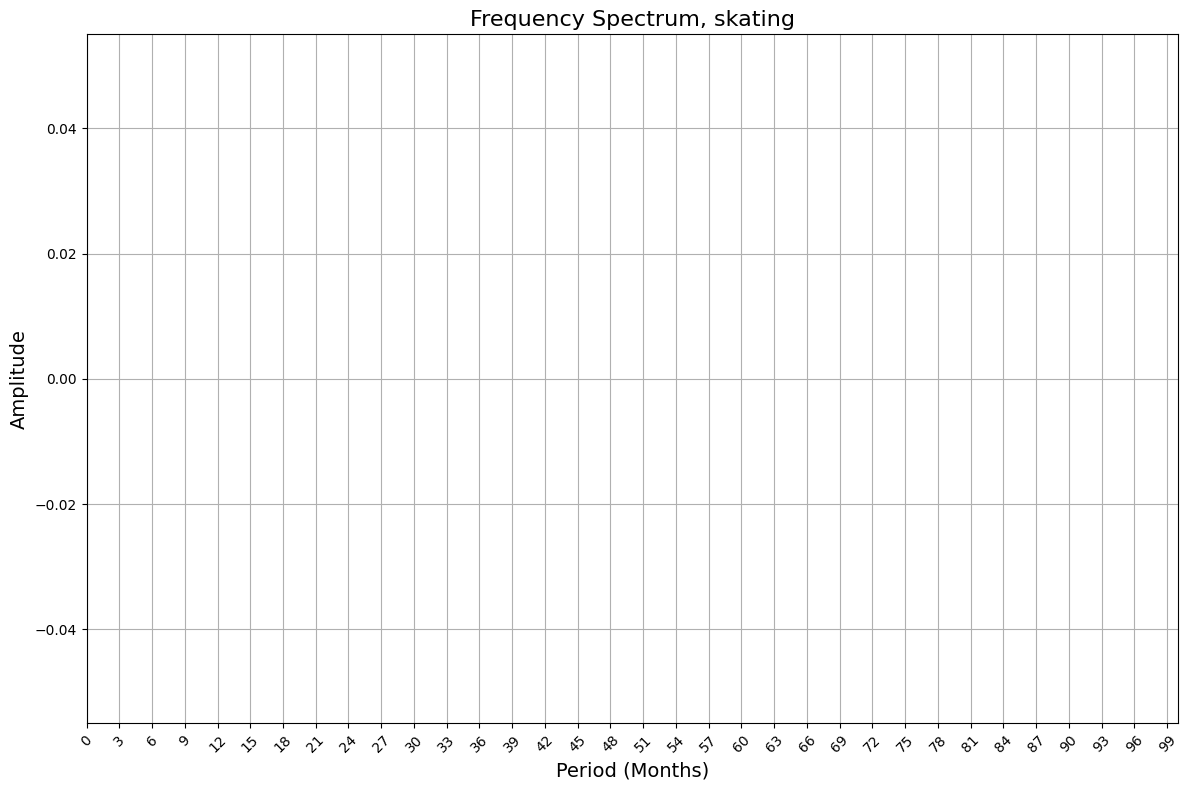

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/2451661569.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


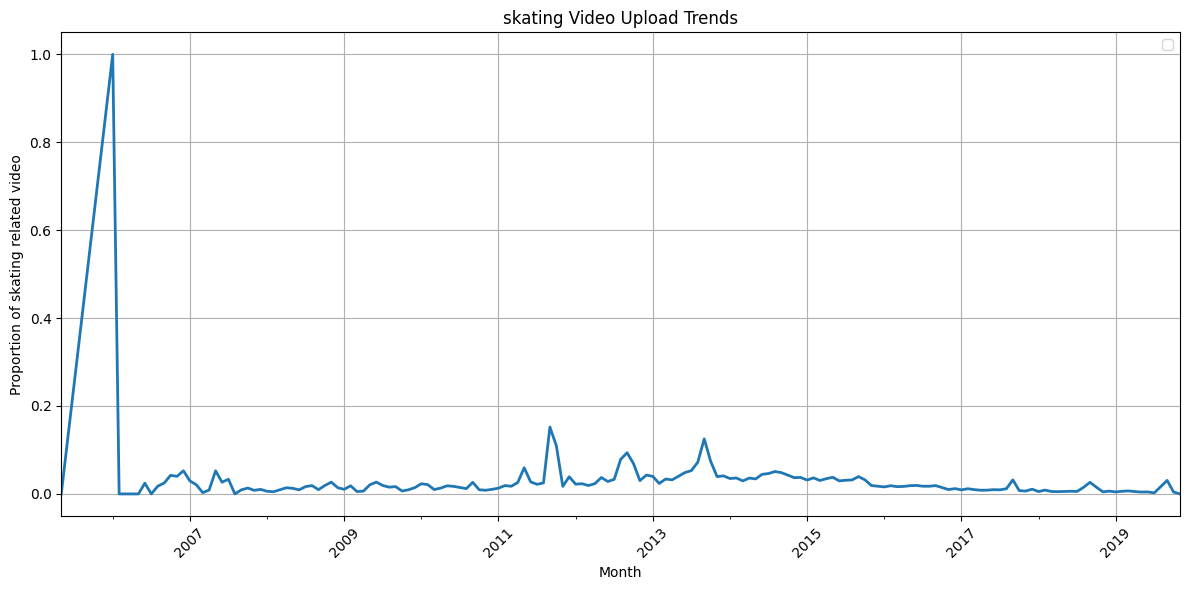

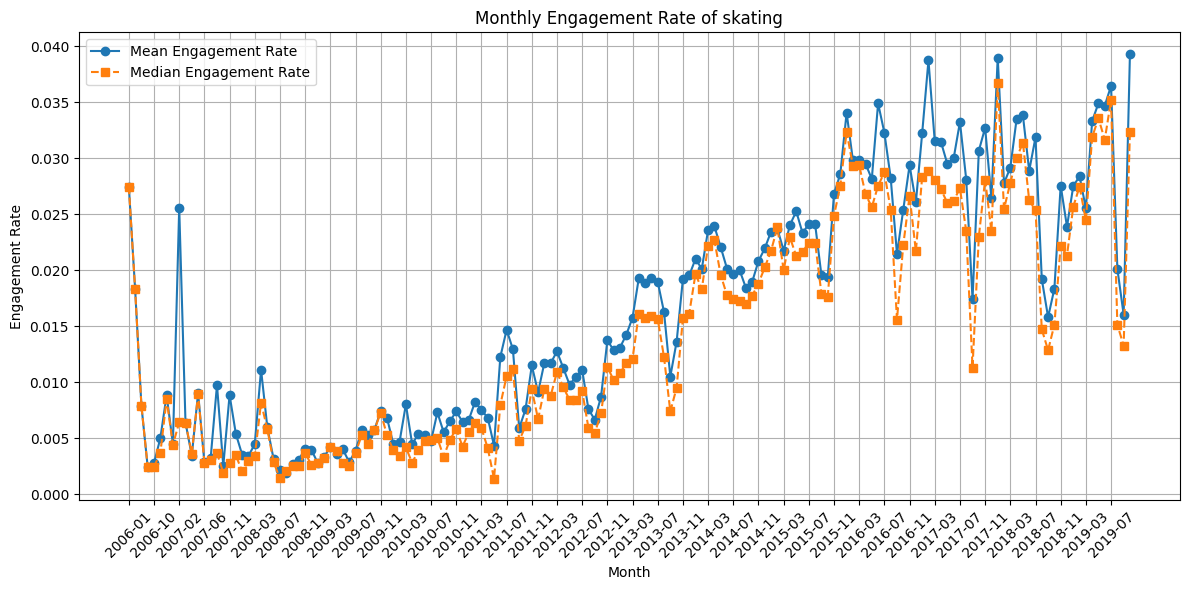

In [42]:
for sport in target_sports:
    df_sport_category_metadata=target_sport_data[target_sport_data['tags'].apply(lambda x: sport in x)]
    sport_analysis(target_sport_data,df_sport_category_metadata,sport)

#### golf

In [16]:
df_golf_sport_category_metadata=target_sport_data[target_sport_data['tags'].apply(lambda x: "golf" in x)]

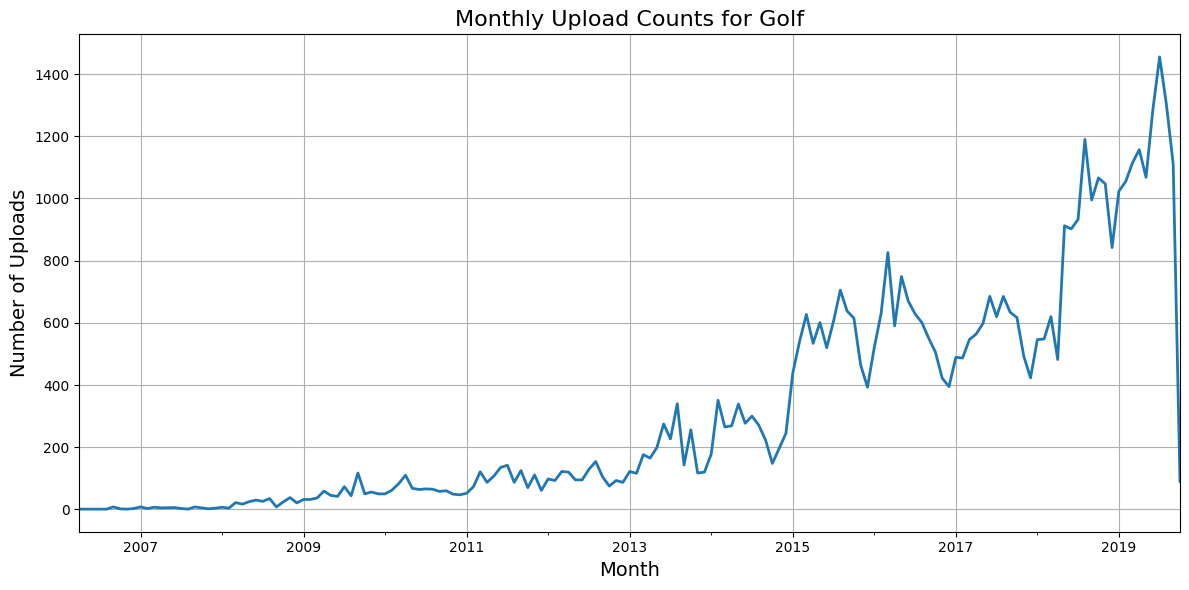

Autocorrelation:  0.94377202563214
periodic analysis
len 159
[159.          79.5         53.          39.75        31.8
  26.5         22.71428571  19.875       17.66666667  15.9
  14.45454545  13.25        12.23076923  11.35714286  10.6
   9.9375       9.35294118   8.83333333   8.36842105   7.95
   7.57142857   7.22727273   6.91304348   6.625        6.36
   6.11538462   5.88888889   5.67857143   5.48275862   5.3
   5.12903226   4.96875      4.81818182   4.67647059   4.54285714
   4.41666667   4.2972973    4.18421053   4.07692308   3.975
   3.87804878   3.78571429   3.69767442   3.61363636   3.53333333
   3.45652174   3.38297872   3.3125       3.24489796   3.18
   3.11764706   3.05769231   3.           2.94444444   2.89090909
   2.83928571   2.78947368   2.74137931   2.69491525   2.65
   2.60655738   2.56451613   2.52380952   2.484375     2.44615385
   2.40909091   2.37313433   2.33823529   2.30434783   2.27142857
   2.23943662   2.20833333   2.17808219   2.14864865   2.12
   2.0921052

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/80556927.py:35: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


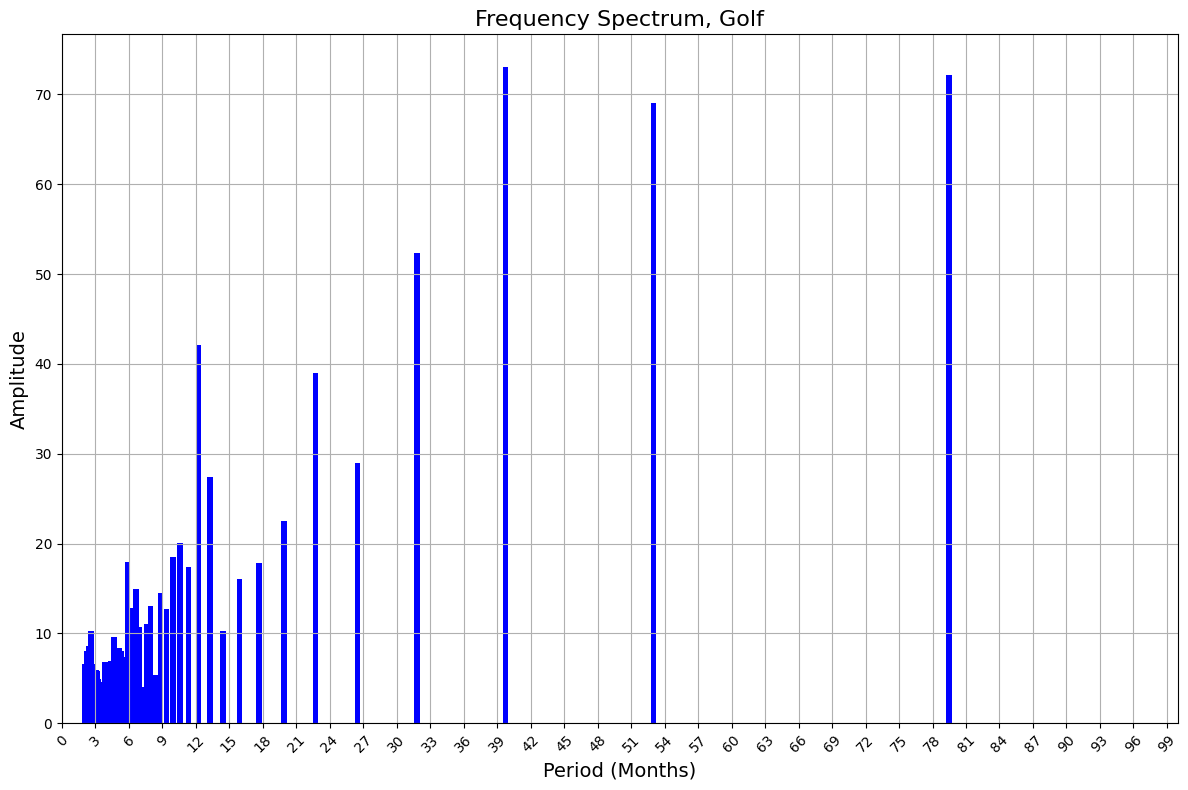

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_38226/80556927.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


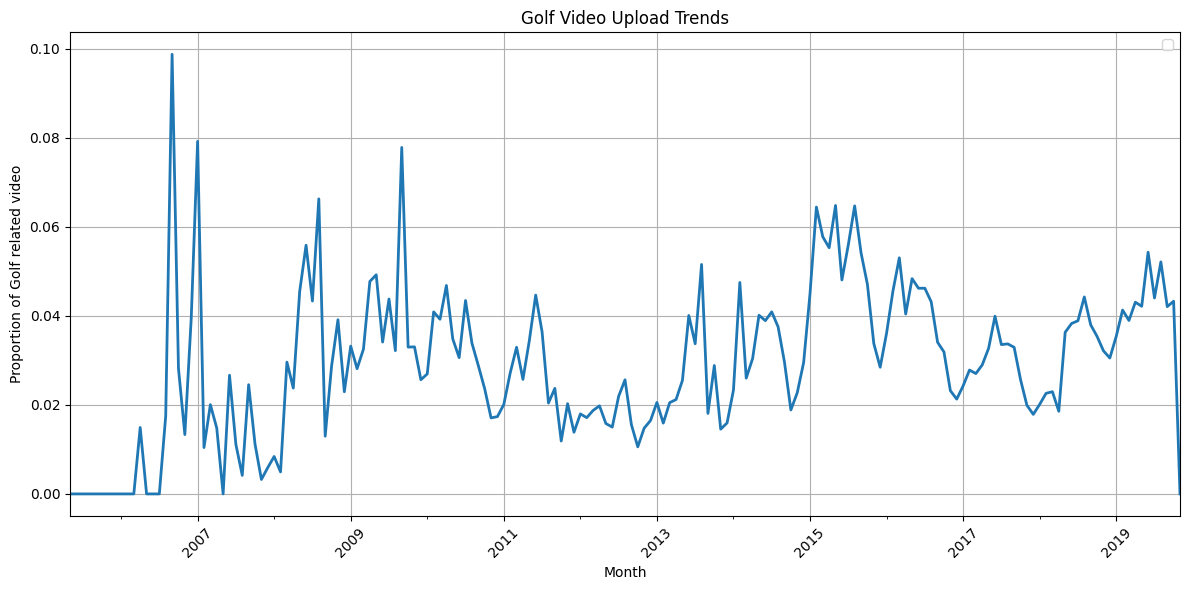

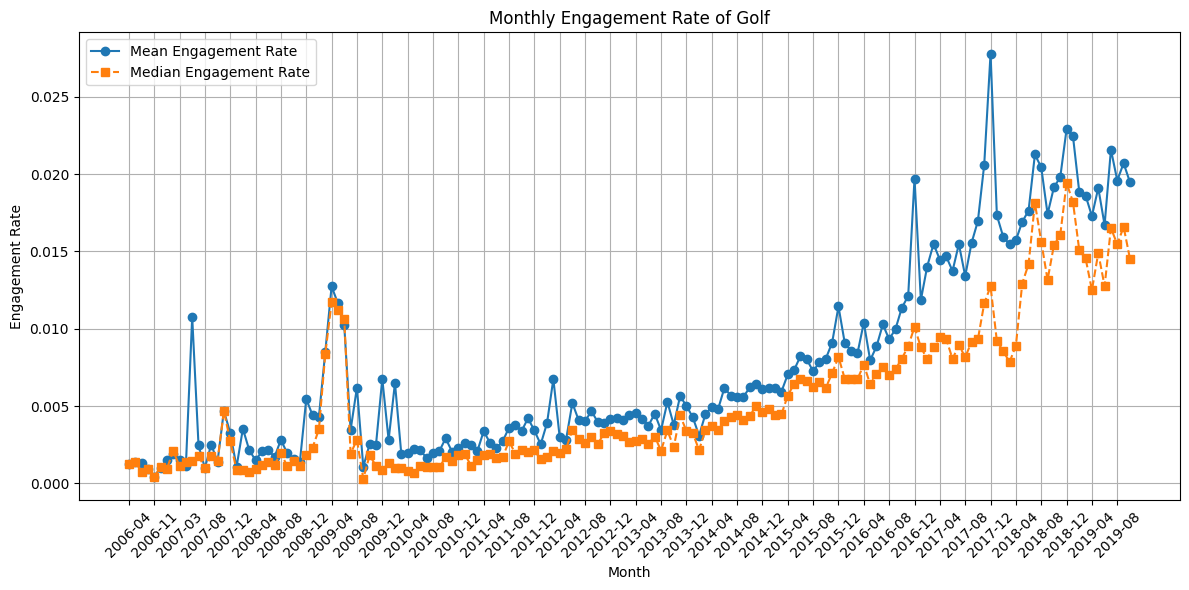

In [40]:
sport_analysis(target_sport_data,df_golf_sport_category_metadata,"Golf")

#### rugby

In [ ]:
df_rugby_sport_category_metadata=target_sport_data[target_sport_data['tags'].apply(lambda x: "rugby" in x)]
df_rugby_sport_category_metadata.shape


In [ ]:
sport_analysis(target_sport_data,df_rugby_sport_category_metadata,"Rugby")

#### Karate

In [ ]:
df_karate_sport_category_metadata=target_sport_data[target_sport_data['tags'].apply(lambda x: "karate" in x)]
df_karate_sport_category_metadata.shape

In [ ]:
sport_analysis(target_sport_data,df_karate_sport_category_metadata,"Karate")

### football

In [ ]:
df_football_sport_category_metadata=target_sport_data[target_sport_data['tags'].apply(lambda x: "football" in x)]
df_football_sport_category_metadata.shape

In [ ]:
sport_analysis(target_sport_data,df_football_sport_category_metadata,"football")

#### table tennis

In [ ]:
df_tabletennis_sport_category_metadata=target_sport_data[target_sport_data['tags'].apply(lambda x: "table_tennis" in x)]
df_tabletennis_sport_category_metadata.shape

In [ ]:
sport_analysis(target_sport_data,df_tabletennis_sport_category_metadata,"teble_tennis")

What happened in early 2011????

In [66]:
df_tabletennis_sport_category_metadata_2011=df_tabletennis_sport_category_metadata[(df_tabletennis_sport_category_metadata['upload_date'].dt.year == 2011)]

In [ ]:
df_tabletennis_sport_category_metadata_2011.value_counts('channel_id')

In [ ]:
df_tabletennis_sport_category_metadata_2011['channel_id'].nunique()

In [ ]:
all_tags_sport = get_all_tags(df_tabletennis_sport_category_metadata_2011)
plot_wordcloud(all_tags_sport, "Word cloud for tags of sports channels")
del all_tags_sport

#### TOP 5 popular sport
football, basketball, wrestling, soccer, boxing